# Forest Fire Cause Prediction

Using a [USDA Forest Service database hosted on Kaggle](https://www.kaggle.com/rtatman/188-million-us-wildfires) of all US forest fires from 1992 to 2015 we will build models to predict the cause of wild fires which occurred in the western US over that timeframe.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
import seaborn as sns
import sqlite3

from sklearn.preprocessing import scale
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SVMSMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score

%matplotlib inline
sns.set_style('whitegrid')
pd.set_option('display.max_columns', 50)

## Data loading and EDA

In [2]:
# Creating a western US DataFrame from the database
conn = sqlite3.connect('FPA_FOD_20170508.sqlite')
query = '''select * 
           from fires
           where STATE in ('WA', 'OR', 'CA', 'ID', 'NV', 'AZ', 'NM', 'UT', 'CO', 'WY', 'MT')'''
df = pd.read_sql_query(query, conn)


In [3]:
df.shape

(566684, 39)

In [4]:
df.head()

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,LOCAL_FIRE_REPORT_ID,LOCAL_INCIDENT_ID,FIRE_CODE,FIRE_NAME,ICS_209_INCIDENT_NUMBER,ICS_209_NAME,MTBS_ID,MTBS_FIRE_NAME,COMPLEX_NAME,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,1,PNF-47,BJ8K,FOUNTAIN,None,None,None,None,None,2005,2453403.5,33,1300,9.0,Miscellaneous,2453403.5,33.0,1730,0.10,A,40.036944,-121.005833,5.0,USFS,CA,63,063,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,13,13,AAC0,PIGEON,None,None,None,None,None,2004,2453137.5,133,0845,1.0,Lightning,2453137.5,133.0,1530,0.25,A,38.933056,-120.404444,5.0,USFS,CA,61,061,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...
2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,27,021,A32W,SLACK,None,None,None,None,None,2004,2453156.5,152,1921,5.0,Debris Burning,2453156.5,152.0,2024,0.10,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA,17,017,El Dorado,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...
3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,43,6,None,DEER,None,None,None,None,None,2004,2453184.5,180,1600,1.0,Lightning,2453189.5,185.0,1400,0.10,A,38.559167,-119.913333,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...
4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,44,7,None,STEVENOT,None,None,None,None,None,2004,2453184.5,180,1600,1.0,Lightning,2453189.5,185.0,1200,0.10,A,38.559167,-119.933056,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...


🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥 

We have records of 566 thousand fires for the western states.

In [5]:
# EEEEEEEEEE DDDDDDDD        A
# E          D       D      A A
# E          D        D    A   A
# EEEEEE     D        D   AAAAAAA
# E          D        D  A       A
# E          D       D   A       A
# EEEEEEEEEE DDDDDDDD    A       A

## Feature Engineering

We will do some feature engineering using the data already present in the database.

1. Converting dates
2. Creating discovery month
3. Imputing discovery time
4. Imputing the containment date
5. Calculating the fire length (in days)
6. Engineering a unique county identification number
7. Dropping missing county FIPS codes
8. Dropping the `Miscellaneous` and `Missing/Undefined` fire causes

### Converting dates, creating discovery month, and imputing discovery time

In [6]:
# Converting from Julian dates to Gregorian
epoch = pd.to_datetime(0, unit='s').to_julian_date()
df['DISC_GREG_DATE'] = pd.to_datetime(df['DISCOVERY_DATE'] - epoch, unit='D')

epoch = pd.to_datetime(0, unit='s').to_julian_date()
df['CONT_GREG_DATE'] = pd.to_datetime(df['CONT_DATE'] - epoch, unit='D')

# Pulling the discovery month
df['DISC_MONTH'] = df['DISC_GREG_DATE'].dt.month

# Imputing the missing dicovery times with the mean
disc_time_mean = pd.to_numeric(df['DISCOVERY_TIME'].dropna()).mean()
df['DISCOVERY_TIME'].fillna(disc_time_mean, inplace=True)


### Imputing containment date, calculating the fire burn length

In [7]:
# Creating a dataframe with date and size variables, dropping the NaN's
fire_dates = df[['DISCOVERY_DOY', 
                 'CONT_DOY',  
                 'FIRE_SIZE_CLASS']].copy()
fire_dates.dropna(inplace=True)

# Creating a variable for length of fire
fire_dates['Fire_length'] = fire_dates['CONT_DOY'] - fire_dates['DISCOVERY_DOY']

# Some fires that started and ended in different years are causing erroneous min/max values.
# Changing those values to NaN and then dropping them
fire_dates['Fire_length'].where((fire_dates['Fire_length'] < 300), np.NaN, inplace=True)
fire_dates['Fire_length'].where((fire_dates['Fire_length'] > 0), np.NaN, inplace=True)
fire_dates.dropna(inplace=True)


# Getting the mean `FIRE_LENGTH` by grouped `FIRE_SIZE_CLASS`
length_fireclass_mean = fire_dates.groupby('FIRE_SIZE_CLASS')['Fire_length'].mean()

# Creating a timedelta variable for each fire size class
fireclassA_length = pd.to_timedelta(length_fireclass_mean[0], unit='D')
fireclassB_length = pd.to_timedelta(length_fireclass_mean[1], unit='D')
fireclassC_length = pd.to_timedelta(length_fireclass_mean[2], unit='D')
fireclassD_length = pd.to_timedelta(length_fireclass_mean[3], unit='D')
fireclassE_length = pd.to_timedelta(length_fireclass_mean[4], unit='D')
fireclassF_length = pd.to_timedelta(length_fireclass_mean[5], unit='D')
fireclassG_length = pd.to_timedelta(length_fireclass_mean[6], unit='D')

In [8]:
def fireMeanLength(x):
    if x == 'A':
        return fireclassA_length
    elif x == 'B':
        return fireclassB_length
    elif x == 'C':
        return fireclassC_length
    elif x == 'D':
        return fireclassD_length
    elif x == 'E':
        return fireclassE_length
    elif x == 'F':
        return fireclassF_length
    elif x == 'G':
        return fireclassG_length

# Creating a new column in the main dataframe with the mean fire length
# by fire size group
df['FIRE_MEAN_LENGTH'] = df['FIRE_SIZE_CLASS'].apply(lambda x: fireMeanLength(x))

# Creating a column of calculated containment dates
df['Calc_CONT_DATE'] = df['DISC_GREG_DATE'] + df['FIRE_MEAN_LENGTH']

# Filling all missing data in CONT_GREG_DATE with the calculated date
df['CONT_GREG_DATE'].fillna(value=df['Calc_CONT_DATE'], inplace=True)

# Calculating the burn length of fire
df['FIRE_LENGTH'] = df['CONT_GREG_DATE'] - df['DISC_GREG_DATE']

# Changing the dtype of Fire_length to integer
df['FIRE_LENGTH'] = df['FIRE_LENGTH'].dt.days


In [9]:
# Dropping the Missing and Miscellaneous fire causes
df = df[~df['STAT_CAUSE_DESCR'].isin(['Miscellaneous', 'Missing/Undefined'])]


In [10]:
# List of causes to label the model confusion matrices
cause_labels = ['Lightning',
                'Equipment Use',
                'Smoking',
                'Campfire',
                'Debris Burning',
                'Railroad',
                'Arson',
                'Children',
                'Fireworks',
                'Powerline',
                'Structure']

### County FIPS code engineering

In [11]:
# Dropping any fire with a missing county-level `FIPS_CODE`
df = df.dropna(subset=['FIPS_CODE'], axis=0)


# Dictionary containing the abbreviated state name 
# and it's associated state-level FIPS code
state_FIPS = {
    'AZ': '04',
    'CA': '06',
    'CO': '08',
    'ID': '16',
    'MT': '30',
    'NV': '32',
    'NM': '35',
    'OR': '41',
    'UT': '49',
    'WA': '53',
    'WY': '56',
}

# Creating a new column with the State-level FIPS code
df['STATE_FIPS'] = df['STATE'].map(state_FIPS)

# Prepending the state code to the county code
df['FULL_FIPS'] = df[['STATE_FIPS', 'FIPS_CODE']].apply(''.join, axis=1)

# Dropping the parent columns to the FULL_FIPS columns
df.drop(columns=['FIPS_CODE', 'STATE_FIPS'], inplace=True)

## Full feature EDA

In [12]:
# EEEEEEEEEE DDDDDDDD        A
# E          D       D      A A
# E          D        D    A   A
# EEEEEE     D        D   AAAAAAA
# E          D        D  A       A
# E          D       D   A       A
# EEEEEEEEEE DDDDDDDD    A       A

## Model Prep

Creating the model input dataframe, scaling, one-hot-encoding, label encoding, and spliting the data.

In [13]:
df_base = df[['STAT_CAUSE_CODE', 
              'DISC_MONTH', 
              'DISCOVERY_TIME', 
              'FIRE_LENGTH', 
              'FIRE_SIZE_CLASS', 
              'STATE', 
              'FULL_FIPS', 
              'OWNER_DESCR']]

In [14]:
df_base.shape

(188018, 8)

In [15]:
df_base.head()

,STAT_CAUSE_CODE,DISC_MONTH,DISCOVERY_TIME,FIRE_LENGTH,FIRE_SIZE_CLASS,STATE,FULL_FIPS,OWNER_DESCR
1,1.0,5,0845,0,A,CA,06061,USFS
2,5.0,5,1921,0,A,CA,06017,STATE OR PRIVATE
3,1.0,6,1600,5,A,CA,06003,USFS
4,1.0,6,1600,5,A,CA,06003,USFS
5,1.0,6,1800,1,A,CA,06005,USFS


In [16]:
# Scaling the continuous input features
df_base['DISC_MONTH'] = scale(df_base['DISC_MONTH'].copy())
df_base['DISCOVERY_TIME'] = scale(df_base['DISCOVERY_TIME'].copy())
df_base['FIRE_LENGTH'] = scale(df_base['FIRE_LENGTH'].copy())

/Users/mkfrancsis/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/Users/mkfrancsis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/mkfrancsis/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/Users/mkfrancsis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

Linear-based models require categorical features to be one-hot-encoded.

In [17]:
def onehot(df, cols):
    '''One hot encode the categoricals, then drop the original columns'''
    for c in cols:
        dummies = pd.get_dummies(df[c], prefix=c, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
        df.drop(columns=c, inplace=True)
    return df

# Selecting the categorical features and OHE them
onehotcolumns = df_base.columns[-4:]
df_ohe_final = onehot(df_base, onehotcolumns)

In [18]:
df_ohe_final.shape

(188018, 449)

In [19]:
# Creating the target and input features
Y_ohe = df_ohe_final['STAT_CAUSE_CODE']
X_ohe = df_ohe_final.iloc[:, 1:].copy()

Tree-based models can use OHE features, however, they perform better when the labels are simply numerically encoded.

In [20]:
# We don't want OHE categorical variables in the Random Forest Model
# Reselecting the X values and encoding the categorical variables
df_rf_final = df_base.copy()

# FIRE_SIZE_CLASS encoding
le_FSC = LabelEncoder()
df_rf_final['FIRE_SIZE_CLASS'] = le_FSC.fit_transform(df_rf_final['FIRE_SIZE_CLASS'])

# STATE encoding
le_STATE = LabelEncoder()
df_rf_final['STATE'] = le_STATE.fit_transform(df_rf_final['STATE'])

# FIPS encoding
le_FIPS = LabelEncoder()
df_rf_final['FULL_FIPS'] = le_FIPS.fit_transform(df_rf_final['FULL_FIPS'])

# OWNER DESCR encoding
le_OWN = LabelEncoder()
df_rf_final['OWNER_DESCR'] = le_OWN.fit_transform(df_rf_final['OWNER_DESCR'])


In [21]:
df_rf_final.shape

(188018, 8)

In [22]:
# Creating the target and input features
Y_rf = df_rf_final['STAT_CAUSE_CODE']
X_rf = df_rf_final.iloc[:, 1:].copy()

In [23]:
# Splitting the data, using stratify because of the class imbalance and 
# random state because we will need to do this split for linear models and tree-based models
X_train, X_test, Y_train, Y_test = train_test_split(X_ohe, Y_ohe, stratify=Y_ohe, random_state=93692)

# Resplitting the data with the random forest X inputs
X_rf_train, X_rf_test, Y_rf_train, Y_rf_test = train_test_split(X_rf, Y_rf, stratify=Y_ohe, random_state=93692)

In [24]:
print('Split data shapes')
print('X_train', X_train.shape)
print('X_rf_train', X_rf_train.shape)
print('X_test', X_test.shape)
print('X_rf_test', X_rf_test.shape)

Split data shapes
X_train (141013, 448)
X_rf_train (141013, 7)
X_test (47005, 448)
X_rf_test (47005, 7)


In [25]:
print('Split data fire cause counts')
print('Y_train')
print(Y_train.value_counts(), '\n')
print('Y_test')
print(Y_test.value_counts())

Split data fire cause counts
Y_train
1.0     80950
4.0     14761
2.0     13477
5.0     13255
7.0      7291
3.0      4302
8.0      3310
11.0     1424
6.0      1265
10.0      759
12.0      219
Name: STAT_CAUSE_CODE, dtype: int64 

Y_test
1.0     26984
4.0      4921
2.0      4492
5.0      4418
7.0      2430
3.0      1434
8.0      1104
11.0      474
6.0       422
10.0      253
12.0       73
Name: STAT_CAUSE_CODE, dtype: int64


# Logistic Regression Models

In [26]:
# # Grid search for Ridge Regression

# C_list = [.9, .75, .5, .25, .1, .01, .001]

# print('C\tBalAccTrn\tBalAccTst\tWF1 Trn\tWF1 Tst')
# for c in C_list:
#     ridge = LogisticRegression(solver='lbfgs', 
#                                penalty='l2', 
#                                multi_class='multinomial', 
#                                C=c, 
#                                max_iter=500, 
#                                n_jobs=3)
#     ridge.fit(X_train, Y_train)
#     Y_pred = ridge.predict(X_test)
#     Y_pred_tr = ridge.predict(X_train)
    
#     BalAccTrn = balanced_accuracy_score(Y_train, Y_pred_tr)
#     BalAccTst = balanced_accuracy_score(Y_test, Y_pred)
#     WF1Trn = f1_score(Y_train, Y_pred_tr, average='weighted')
#     WF1Tst = f1_score(Y_test, Y_pred, average='weighted')

#     print(c, '\t', BalAccTrn, '\t', BalAccTst, '\t', WF1Trn, '\t', WF1Tst)

In [27]:
# Grid search results

# C		 BalAccTrn				 BalAccTst				 WF1 Trn				 WF1 Tst
# 0.9 	 0.2105270404199451 	 0.2097857060546964 	 0.6057883050332887 	 0.6039820542088578
# 0.75 	 0.2103266164992642 	 0.20978427177263195 	 0.6055667786997726 	 0.6039383271116653
# 0.5 	 0.20960125084597744 	 0.20907295152560715 	 0.6052536505640604 	 0.6036047108091672
# 0.25 	 0.2080566407546878 	 0.20789188415596876 	 0.6043850363891757 	 0.6031259257647051
# 0.1 	 0.20362811114383875 	 0.20192263079920394 	 0.6010578609495406 	 0.5991246518181774
# 0.01 	 0.1784783355840945 	 0.1779985036797502 	 0.5703539596090671 	 0.5698858498212737
# 0.001  0.14610933425726874 	 0.14606120111760637 	 0.5191659315068627 	 0.5191783322549222

Top ridge regression model had $C = 0.9$

In [28]:
# # Grid search for LASSO Regression

# C_list = [.5, .25, .1, .01, .001]

# print('C\tBalAccTrn\t\tBalAccTst\t\t\tWF1 Trn\t\t\tWF1 Tst')
# for c in C_list:
#     lasso = LogisticRegression(solver='saga', 
#                                penalty='l1', 
#                                multi_class='multinomial', 
#                                C=c, 
#                                max_iter=100, 
#                                n_jobs=-1)
#     lasso.fit(X_train, Y_train)
#     Y_pred = lasso.predict(X_test)
#     Y_pred_tr = lasso.predict(X_train)
    
#     BalAccTrn = balanced_accuracy_score(Y_train, Y_pred_tr)
#     BalAccTst = balanced_accuracy_score(Y_test, Y_pred)
#     WF1Trn = f1_score(Y_train, Y_pred_tr, average='weighted')
#     WF1Tst = f1_score(Y_test, Y_pred, average='weighted')

#     print(c, '\t', BalAccTrn, '\t', BalAccTst, '\t', WF1Trn, '\t', WF1Tst)

In [29]:
# Stopped the grid search early. Both models had failed to converge and
# had generally poor results.  Models were taking ~30 min each.

# C		 BalAccTrn				 BalAccTst				 WF1 Trn				 WF1 Tst
# 0.5 	 0.18979711346693715 	 0.18763113416143645 	 0.5854697457882384 	 0.5831845898336889
# 0.25 	 0.18896528702232354 	 0.18702070551143235 	 0.5843259371720693 	 0.5823932975389334

The best logistic model was a ridge regression.  Let's run that top Ridge model and interrogate it's results more thoroughly.

In [30]:
# Best ridge logistic regression model from the grid search
ridge = LogisticRegression(solver='lbfgs', 
                           penalty='l2', 
                           multi_class='multinomial', 
                           C=.9, 
                           max_iter=500, 
                           n_jobs=3)
ridge.fit(X_train, Y_train)
Y_pred_ridge = ridge.predict(X_test)

# Calculating model metrics
BalAccTst = balanced_accuracy_score(Y_test, Y_pred_ridge)
WF1Tst = f1_score(Y_test, Y_pred_ridge, average='weighted')
# class_report = classification_report(Y_test, Y_pred, labels=cause_labels)  # Error due to some classes not predicted

print('Balanced Accuracy :', BalAccTst)
print('Weighted F1 :', WF1Tst)
# print(class_report)

# Total number of predictions per class from the ridge model.
ridge_results = pd.DataFrame(Y_pred_ridge)[0].value_counts()
print(ridge_results)

Balanced Accuracy : 0.2098110773495569
Weighted F1 : 0.6040154541268807
1.0     34024
2.0      4993
5.0      4828
4.0      2060
7.0       714
3.0       268
11.0       58
8.0        31
6.0        18
10.0       11
Name: 0, dtype: int64


/Users/mkfrancsis/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The ridge model does not predict any `STAT_CAUSE_CODE = 12 (Structure)` fires.

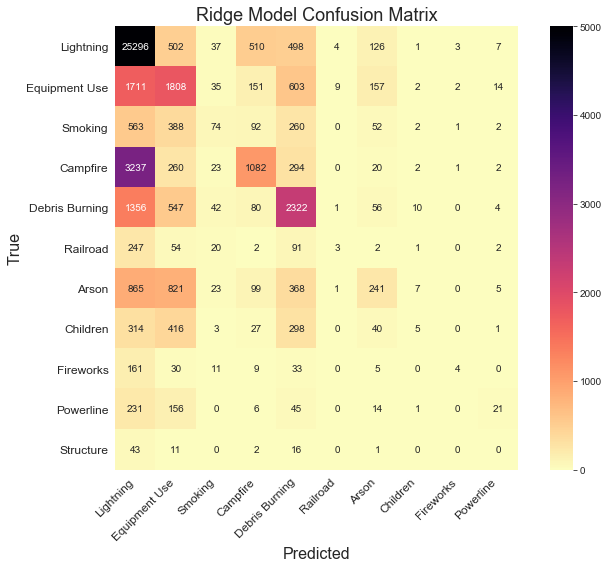

In [31]:
# Ridge confusion matrix
ridge_cfmx = pd.crosstab(Y_test, Y_pred_ridge)

ridge_labels = ['Lightning',
                'Equipment Use',
                'Smoking',
                'Campfire',
                'Debris Burning',
                'Railroad',
                'Arson',
                'Children',
                'Fireworks',
                'Powerline']

plt.figure(figsize=(10,8))
sns.heatmap(ridge_cfmx, 
            xticklabels = ridge_labels, 
            yticklabels = cause_labels,
            annot = True,
            fmt = 'g',
            square = True, 
            vmax = 5000,
            vmin = 0,
            cmap = 'magma_r')
plt.title('Ridge Model Confusion Matrix', size=18)
plt.ylabel('True', size=16)
plt.yticks(size=12)
plt.xlabel('Predicted', size=16)
plt.xticks(rotation=45, size=12, horizontalalignment='right')
plt.tight_layout()
plt.savefig('./Figures/Ridge_lbfgs_c0.9_cfmx.png', dpi=300, transparent=True)
plt.show()

# Random Forest Models

In [32]:
# # Grid search for Random Forest model

# criterion = ['gini']
# n_est = [10, 100, 250, 500]
# max_depth = [10, 20, 30, 40, 50]

# print('Crit\tN_est\tMaxDep\tBalAccTst\tWF1Tst')
# for crit in criterion:
#     for n in n_est:
#         for md in max_depth:
#             rfc = RandomForestClassifier(criterion=crit, 
#                                              n_estimators=n, 
#                                              max_depth=md, 
#                                              n_jobs=-1)
#             rfc.fit(X_rf_train, Y_rf_train)
#             Y_rfc_pred = rfc.predict(X_rf_test)
            
#             BalAccTst = balanced_accuracy_score(Y_rf_test, Y_rfc_pred)
#             WF1Tst = f1_score(Y_rf_test, Y_rfc_pred, average='weighted')

#             print(crit, ', ', n, ', ', md, ':\t', BalAccTst, '\t', WF1Tst)

In [33]:
# Grid search results for random forest

# Crit	N_est	MaxDep	BalAccTst				WF1Tst
# gini ,  10 ,  10 :	 0.2105058892088678 	 0.6128142364964503
# gini ,  10 ,  20 :	 0.2697298743627952 	 0.6530125344111692
# gini ,  10 ,  30 :	 0.27382995415994743 	 0.6451520554385356
# gini ,  10 ,  40 :	 0.2769529876176943 	 0.6466759704854379
# gini ,  10 ,  50 :	 0.27565804626325874 	 0.6469100494345915
# gini ,  100 ,  10 :	 0.2097125247199604 	 0.6107062628027932
# gini ,  100 ,  20 :	 0.2717902187477581 	 0.6589890952296289
# gini ,  100 ,  30 :	 0.2808912664221796 	 0.6526895942783805
# gini ,  100 ,  40 :	 0.27927602929968165 	 0.6519430378063216
# gini ,  100 ,  50 :	 0.28083538728293356 	 0.6524869656130261
# gini ,  250 ,  10 :	 0.21303258552324159 	 0.6128898357392595
# gini ,  250 ,  20 :	 0.27244629816059657 	 0.6595565845076753
# gini ,  250 ,  30 :	 0.28027409855339325 	 0.6527146352403456
# gini ,  250 ,  40 :	 0.2802513749894005 	 0.6533218484659354
# gini ,  250 ,  50 :	 0.2805950137604614 	 0.6526981910068745
# gini ,  500 ,  10 :	 0.21350139709912588 	 0.6134585346768533
# gini ,  500 ,  20 :	 0.2739710742275082 	 0.6605199088536092  # Best WF1 score
# gini ,  500 ,  30 :	 0.2796060878223359 	 0.6532724591887067
# gini ,  500 ,  40 :	 0.27910793405326334 	 0.6525098852124822
# gini ,  500 ,  50 :	 0.2810460651029031 	 0.6530558167672895  # Best BalAcc score

Balanced accuracy:  0.27301117298682426
Weighted F1 score:  0.6605983761465862


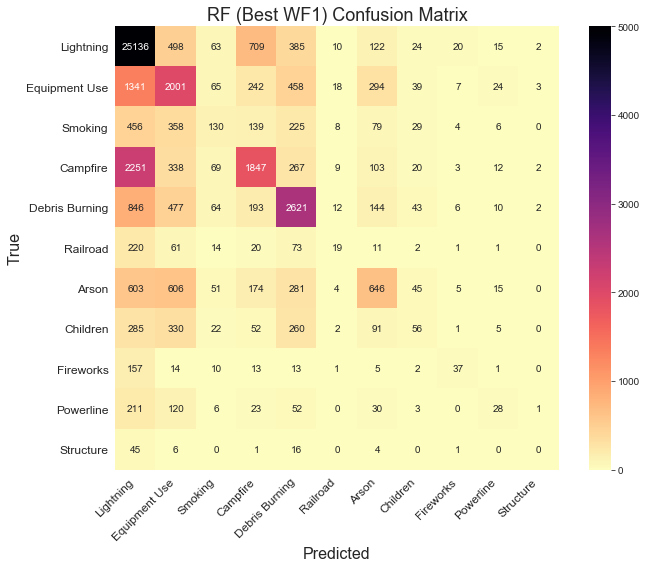

In [83]:
# Random forest model with best WF1 score

rfc = RandomForestClassifier(criterion='gini', 
                                 n_estimators=500, 
                                 max_depth=20, 
                                 n_jobs=-1)
rfc.fit(X_rf_train, Y_rf_train)
Y_rfc_pred = rfc.predict(X_rf_test)

# Model metrics
BalAccTst_rfc = balanced_accuracy_score(Y_rf_test, Y_rfc_pred)
WF1Tst_rfc = f1_score(Y_rf_test, Y_rfc_pred, average='weighted')

print('Balanced accuracy: ', BalAccTst_rfc)
print('Weighted F1 score: ', WF1Tst_rfc)


# Random forest model with best WF1 score confusion matrix
rfc_cfmx = pd.crosstab(Y_rf_test, Y_rfc_pred)

plt.figure(figsize=(10,8))
sns.heatmap(rfc_cfmx, 
            xticklabels = cause_labels, 
            yticklabels = cause_labels,
            annot = True,
            fmt = 'g',
            square = True, 
            vmax = 5000,
            vmin = 0,
            cmap = 'magma_r')
plt.title('RF (Best WF1) Confusion Matrix', size=18)
plt.ylabel('True', size=16)
plt.yticks(size=12)
plt.xlabel('Predicted', size=16)
plt.xticks(rotation=45, size=12, horizontalalignment='right')
plt.tight_layout()
plt.savefig('./Figures/RF_gini_n500_md20_BestWF1.png', dpi=300, transparent=True)
plt.show()

Balanced accuracy:  0.28033220814838505
Weighted F1 score:  0.6531382892014288


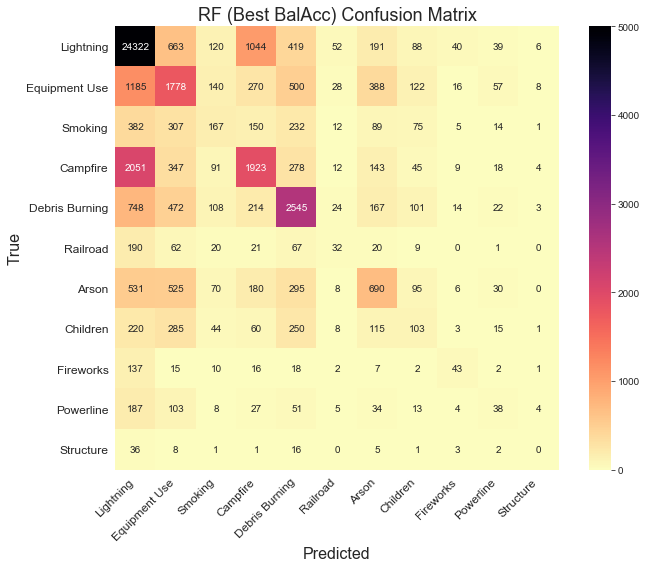

In [36]:
# Random forest model with best BalAcc score

rfc = RandomForestClassifier(criterion='gini', 
                                 n_estimators=500, 
                                 max_depth=50, 
                                 n_jobs=-1)
rfc.fit(X_rf_train, Y_rf_train)
Y_rfc_pred = rfc.predict(X_rf_test)

# Model metrics
BalAccTst_rfc = balanced_accuracy_score(Y_rf_test, Y_rfc_pred)
WF1Tst_rfc = f1_score(Y_rf_test, Y_rfc_pred, average='weighted')

print('Balanced accuracy: ', BalAccTst_rfc)
print('Weighted F1 score: ', WF1Tst_rfc)


# Random forest model with best WF1 score confusion matrix
rfc_cfmx = pd.crosstab(Y_rf_test, Y_rfc_pred)

plt.figure(figsize=(10,8))
sns.heatmap(rfc_cfmx, 
            xticklabels = cause_labels, 
            yticklabels = cause_labels,
            annot = True,
            fmt = 'g',
            square = True, 
            vmax = 5000,
            vmin = 0,
            cmap = 'magma_r')
plt.title('RF (Best BalAcc) Confusion Matrix', size=18)
plt.ylabel('True', size=16)
plt.yticks(size=12)
plt.xlabel('Predicted', size=16)
plt.xticks(rotation=45, size=12, horizontalalignment='right')
plt.tight_layout()
plt.savefig('./Figures/RF_gini_n500_md50_BestBalAcc.png', dpi=300, transparent=True)
plt.show()

Those models produce almost identical results.

# Gradient Boosted Trees

      Iter       Train Loss   Remaining Time 
         1      267915.5089            1.55m
         2      245872.7685            1.46m
         3      229931.2460            1.44m
         4      217724.2291            1.41m
         5      207038.7958            1.39m
         6      199338.5163            1.35m
         7      192228.8272            1.33m
         8      186713.2808            1.32m
         9      182290.3572            1.30m
        10      178130.9366            1.29m
        20      158775.3716            1.15m
        30      151861.4921            1.02m
        40      148107.3075           52.05s
        50      145695.5342           43.32s
        60      143844.9141           34.73s
        70      142314.6694           25.70s
        80      141087.4990           16.97s
        90      140033.5788            8.38s
       100      139113.1481            0.00s
Balanced accuracy:  0.2314732178217052
Weighted F1 score:  0.6262077223188961


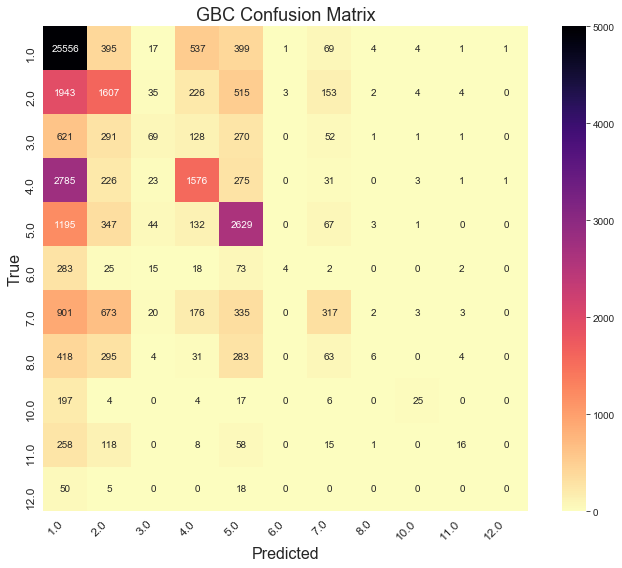

In [37]:
# Gradient Boosted Trees, sklearn defaults

gbc = GradientBoostingClassifier(verbose=1)
gbc.fit(X_rf_train, Y_rf_train)
Y_gbc_pred = gbc.predict(X_rf_test)

# Model metrics
BalAccTst_gbc = balanced_accuracy_score(Y_rf_test, Y_gbc_pred)
WF1Tst_gbc = f1_score(Y_rf_test, Y_gbc_pred, average='weighted')

print('Balanced accuracy: ', BalAccTst_gbc)
print('Weighted F1 score: ', WF1Tst_gbc)


# Gradient Boosted Trees confusion matrix
gbc_cfmx = pd.crosstab(Y_rf_test, Y_gbc_pred)

plt.figure(figsize=(10,8))
sns.heatmap(gbc_cfmx, 
#             xticklabels = cause_labels, 
#             yticklabels = cause_labels,
            annot = True,
            fmt = 'g',
            square = True, 
            vmax = 5000,
            vmin = 0,
            cmap = 'magma_r')
plt.title('GBC Confusion Matrix', size=18)
plt.ylabel('True', size=16)
plt.yticks(size=12)
plt.xlabel('Predicted', size=16)
plt.xticks(rotation=45, size=12, horizontalalignment='right')
plt.tight_layout()
# plt.savefig('./Figures/RF_gini_n500_md50_BestBalAcc.png', dpi=300, transparent=True)
plt.show()

In [38]:
# # Grid search for Gradient Boosted Trees

# n_est = [100, 250, 500]
# learningrate = [1, .5, .25, .1, .05]
# maxdepth = [2, 3, 4, 5]

# print('n_est\tlearn\tMaxDep\tBalAcc\tWF1')
# for n in n_est:
#     for lr in learningrate:
#         for md in maxdepth:
#             gbc = GradientBoostingClassifier(n_estimators = n, 
#                                              learning_rate = lr,
#                                              max_depth = md,
#                                              n_iter_no_change = 3)
#             gbc.fit(X_rf_train, Y_rf_train)
#             Y_gbc_pred = gbc.predict(X_rf_test)

#             # Model metrics
#             BalAccTst_gbc = balanced_accuracy_score(Y_rf_test, Y_gbc_pred)
#             WF1Tst_gbc = f1_score(Y_rf_test, Y_gbc_pred, average='weighted')

#             print(n, '\t', lr, '\t', md, '\t', BalAccTst_gbc, '\t', WF1Tst_gbc)

In [39]:
# Grid search results for GBC

# n_est	learn	MaxDep	BalAcc			WF1
# 100 	 1 	 2 	 0.10127706208624083 	 0.00466947665218936
# 100 	 1 	 3 	 0.0896721383072384 	 0.2831866699866764
# 100 	 1 	 4 	 0.06163105187801668 	 0.008826663308770787
# 100 	 1 	 5 	 0.0833120616937907 	 0.016014942777525323
# 100 	 0.5 	 2 	 0.2334835634662375 	 0.6278421324296289
# 100 	 0.5 	 3 	 0.23275226841564373 	 0.6269510180774085
# 100 	 0.5 	 4 	 0.239473592616047 	 0.6248087571109695
# 100 	 0.5 	 5 	 0.2716380905805536 	 0.65699192174367    
# 100 	 0.25 	 2 	 0.20062596785830528 	 0.5981356808533618
# 100 	 0.25 	 3 	 0.2482437740798532 	 0.6409806672382058
# 100 	 0.25 	 4 	 0.2572871303285135 	 0.6496041244968466
# 100 	 0.25 	 5 	 0.2598589775227648 	 0.6529728703235014
# 100 	 0.1 	 2 	 0.19975352278899508 	 0.5965967866542264
# 100 	 0.1 	 3 	 0.2292912484873436 	 0.6250270989136085
# 100 	 0.1 	 4 	 0.25441786304733155 	 0.6448334129405917
# 100 	 0.1 	 5 	 0.26843306374547865 	 0.6565623004746102
# 100 	 0.05 	 2 	 0.17998051317481445 	 0.5737212475859044
# 100 	 0.05 	 3 	 0.20370146963284624 	 0.6010808758377818
# 100 	 0.05 	 4 	 0.2269454689359841 	 0.6249437029353467
# 100 	 0.05 	 5 	 0.2449229210700232 	 0.640033282480623
# 250 	 1 	 2 	 0.10127706208624083 	 0.00466947665218936
# 250 	 1 	 3 	 0.07642180934061486 	 0.2437323194486221
# 250 	 1 	 4 	 0.07435855872504758 	 0.01566518593205764
# 250 	 1 	 5 	 0.06962404753488899 	 0.16912310853826143
# 250 	 0.5 	 2 	 0.22683142404414314 	 0.6209362747930754
# 250 	 0.5 	 3 	 0.22119630102235763 	 0.6122984876635559
# 250 	 0.5 	 4 	 0.25436289105436205 	 0.6435151094534092
# 250 	 0.5 	 5 	 0.26774898822837384 	 0.6544449558801181
# 250 	 0.25 	 2 	 0.2508621552688645 	 0.6474962343777843
# 250 	 0.25 	 3 	 0.20413139297300062 	 0.6001072207062258
# 250 	 0.25 	 4 	 0.2585733505086453 	 0.6511703418863931
# 250 	 0.25 	 5 	 0.25710958390201544 	 0.6484190699908903
# 250 	 0.1 	 2 	 0.22740866238426616 	 0.6239896245707746
# 250 	 0.1 	 3 	 0.25904101645970506 	 0.651317590339021
# 250 	 0.1 	 4 	 0.2518480885857866 	 0.644766881442704
# 250 	 0.1 	 5 	 0.26923797855249165 	 0.659235223379269   # WF1 & second best BalAcc # Overall winner
# 250 	 0.05 	 2 	 0.20395525186031316 	 0.6024644840337728
# 250 	 0.05 	 3 	 0.23657606914921214 	 0.6313257505063795
# 250 	 0.05 	 4 	 0.25859897595577314 	 0.6491637267840957
# 250 	 0.05 	 5 	 0.2589423965317865 	 0.6532204091642743
# 500 	 1 	 2 	 0.10127706208624083 	 0.00466947665218936
# 500 	 1 	 3 	 0.10855359244075191 	 0.44635636582537663
# 500 	 1 	 4 	 0.09491545166933317 	 0.19098355084729712
# 500 	 1 	 5 	 0.07993292507272233 	 0.03928535634245885
# 500 	 0.5 	 2 	 0.2404606044419107 	 0.6369714689522004
# 500 	 0.5 	 3 	 0.2655948292517818 	 0.6570286550892208
# 500 	 0.5 	 4 	 0.24794676076643424 	 0.6410730952570192
# 500 	 0.5 	 5 	 0.25698346560244595 	 0.6445881028854964
# 500 	 0.25 	 2 	 0.2430914690255286 	 0.644432340892585
# 500 	 0.25 	 3 	 0.23592224690246716 	 0.630774489388616
# 500 	 0.25 	 4 	 0.25994846862144494 	 0.6493625200039349
# 500 	 0.25 	 5 	 0.26735882623526197 	 0.6560944807073462
# 500 	 0.1 	 2 	 0.2430154166758662 	 0.6402790919163933
# 500 	 0.1 	 3 	 0.2623742201854513 	 0.6548042594616219
# 500 	 0.1 	 4 	 0.25715229734926337 	 0.6510568511771385
# 500 	 0.1 	 5 	 0.2600570113757896 	 0.652075172041884
# 500 	 0.05 	 2 	 0.22873406136417976 	 0.6241945244075361
# 500 	 0.05 	 3 	 0.25540394527389726 	 0.6496633902806728
# 500 	 0.05 	 4 	 0.2526649076804597 	 0.645710559034921
# 500 	 0.05 	 5 	 0.26547649615557783 	 0.6561400898527697

      Iter       Train Loss   Remaining Time 
         1      236223.7397            6.87m
         2      214784.1215            6.79m
         3      199211.0423            6.79m
         4      187284.7765            6.76m
         5      177856.7670            6.76m
         6      170380.1938            6.74m
         7      164198.3816            6.72m
         8      159111.5687            6.68m
         9      154967.9161            6.64m
        10      151367.0958            6.62m
        20      132702.2031            6.29m
        30      126052.0625            5.77m
        40      122241.7196            5.28m
        50      119508.1280            4.88m
        60      117418.6642            4.53m
        70      115785.5796            4.23m
        80      114481.1300            3.97m
        90      113166.1116            3.71m
       100      111991.9285            3.45m
Balanced accuracy:  0.26766212421421615
Weighted F1 score:  0.6598475551574562


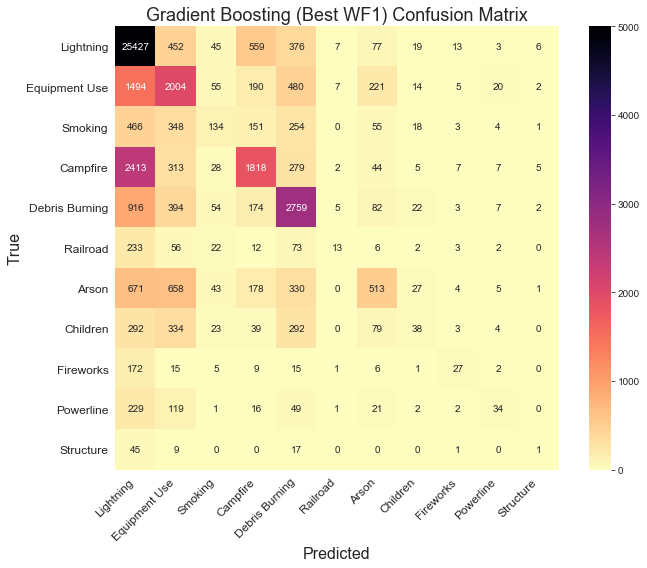

In [40]:
# Gradient Boosted Trees, best WF1 & second best BalAcc model

gbc = GradientBoostingClassifier(n_estimators=250, 
                                 learning_rate=.1, 
                                 max_depth=5,
                                 n_iter_no_change=5, 
                                 verbose=1)
gbc.fit(X_rf_train, Y_rf_train)
Y_gbc_pred = gbc.predict(X_rf_test)

# Model metrics
BalAccTst_gbc = balanced_accuracy_score(Y_rf_test, Y_gbc_pred)
WF1Tst_gbc = f1_score(Y_rf_test, Y_gbc_pred, average='weighted')

print('Balanced accuracy: ', BalAccTst_gbc)
print('Weighted F1 score: ', WF1Tst_gbc)


# Gradient Boosted Trees confusion matrix
gbc_cfmx = pd.crosstab(Y_rf_test, Y_gbc_pred)

plt.figure(figsize=(10,8))
sns.heatmap(gbc_cfmx, 
            xticklabels = cause_labels, 
            yticklabels = cause_labels,
            annot = True,
            fmt = 'g',
            square = True, 
            vmax = 5000,
            vmin = 0,
            cmap = 'magma_r')
plt.title('Gradient Boosting (Best WF1) Confusion Matrix', size=18)
plt.ylabel('True', size=16)
plt.yticks(size=12)
plt.xlabel('Predicted', size=16)
plt.xticks(rotation=45, size=12, horizontalalignment='right')
plt.tight_layout()
plt.savefig('./Figures/GBC_n250_lr0.1_md5_BestWF1.png', dpi=300, transparent=True)
plt.show()

While Gradient Boosting performs similarly to Random Forest on the whole, it overpredicts lightning and thus underpredicts the minority classes more than the Random Forest models.  Additionally, it takes much longer to train because it cannot be parallelized and needs to instantiate an order of magnitude more trees than Random Forest ([see the note in the SKLearn documentation](https://scikit-learn.org/stable/modules/ensemble.html#classification)).  For these reasons, we will move forward with only the Random Forest model from here.

# Random Undersampling

In [41]:
# Dictionary of fire_cause counts equal to the original training split

RUS_dict = {
    1.0: 70950,
    4.0: 14761,
    2.0: 13477,
    5.0: 13255,
    7.0: 7291,
    3.0: 4302,
    8.0: 3310,
    11.0: 1424,
    6.0: 1265,
    10.0: 759,
    12.0: 219
}

In [42]:
# Loop through WF1 RF mode and decrease RUS of Lightning by 10,000 each time

print('Light RUS\tBalAcc\tWF1')

while RUS_dict[1.0] != 10950:
    # Random undersampling the data by decreasing the Lightning
    # class each model run
    rus = RandomUnderSampler(sampling_strategy=RUS_dict)
    X_rus_train, Y_rus_train = rus.fit_resample(X_rf_train, Y_rf_train)
    
    # Instantiating the best WF1 RF model with the undersampled data
    rfc_rus = RandomForestClassifier(criterion = 'gini', 
                                     n_estimators = 500, 
                                     max_depth = 20, 
                                     n_jobs = -1)
    rfc_rus.fit(X_rus_train, Y_rus_train)
    Y_rfc_rus_pred = rfc_rus.predict(X_rf_test)
    
    # Model metrics
    BalAccTst_rfc_rus = balanced_accuracy_score(Y_rf_test, Y_rfc_rus_pred)
    WF1Tst_rfc_rus = f1_score(Y_rf_test, Y_rfc_rus_pred, average='weighted')
    
    print(RUS_dict[1.0], '\t', BalAccTst_rfc_rus, '\t', WF1Tst_rfc_rus)
    
    # Subtracting 10000 from the Lightning class before next loop
    RUS_dict[1.0] -= 10000

70950 	 0.27908126731117255 	 0.6628964680019894
60950 	 0.2830237301262701 	 0.6631341738135323
50950 	 0.28779946982329124 	 0.6627867742819965
40950 	 0.2921772681378838 	 0.6603390572415083
30950 	 0.30154764714111726 	 0.6537211184728803
20950 	 0.30845746435557164 	 0.6380010990186601


Using the best WF1 Random Forest model for the whole data set, we ran through 6 variations of a randomly undersampled Lightning class.  The best WF1 score, 0.664, and the best BalAcc score, 0.304, are both better than the baseline models.

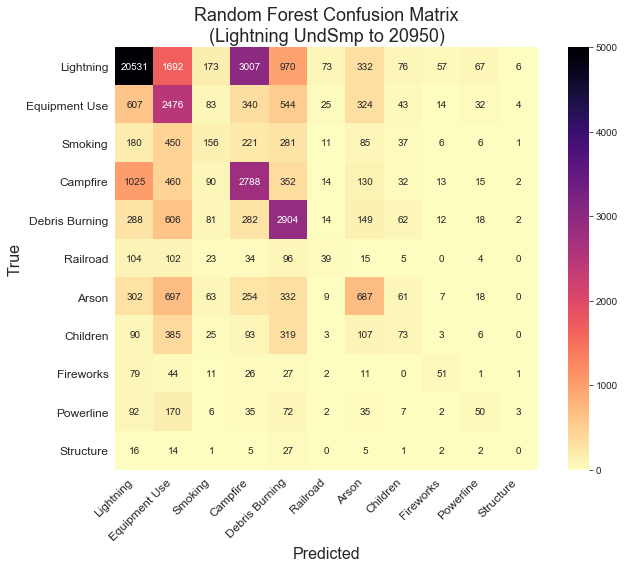

In [43]:
# Best BalAcc score Balanced Random Forest confusion matrix (Lightning = 20950 samples)

rfc_rus_cfmx = pd.crosstab(Y_rf_test, Y_rfc_rus_pred)

plt.figure(figsize=(10,8))
sns.heatmap(rfc_rus_cfmx, 
            xticklabels = cause_labels, 
            yticklabels = cause_labels,
            annot = True,
            fmt = 'g',
            square = True, 
            vmax = 5000,
            vmin = 0,
            cmap = 'magma_r')
plt.title('Random Forest Confusion Matrix\n(Lightning UndSmp to 20950)', size=18)
plt.ylabel('True', size=16)
plt.yticks(size=12)
plt.xlabel('Predicted', size=16)
plt.xticks(rotation=45, size=12, horizontalalignment='right')
plt.tight_layout()
# plt.savefig('./Figures/GBC_n250_lr0.1_md5_BestWF1.png', dpi=300, transparent=True)
plt.show()

In [44]:
# # Grid search for Random Forest model using random under sampled
# # data bringing Lightning class down to 20950 samples.  Best BalAcc model.

## Assigning the random undersampling strategy
# RUS_dict_20950 = {
#     1.0: 20950,
#     4.0: 14761,
#     2.0: 13477,
#     5.0: 13255,
#     7.0: 7291,
#     3.0: 4302,
#     8.0: 3310,
#     11.0: 1424,
#     6.0: 1265,
#     10.0: 759,
#     12.0: 219
# }

## Performing the random undersampling
# rus = RandomUnderSampler(sampling_strategy=RUS_dict_20950)
# X_rus_train, Y_rus_train = rus.fit_resample(X_rf_train, Y_rf_train)
    

# criterion = ['gini']
# n_est = [10, 100, 250, 500]
# max_depth = [10, 20, 30, 40, 50]

# print('Crit\tN_est\tMaxDep\tBalAccTst\tWF1Tst')
# for crit in criterion:
#     for n in n_est:
#         for md in max_depth:
#             rfc_rus = RandomForestClassifier(criterion=crit, 
#                                              n_estimators=n, 
#                                              max_depth=md, 
#                                              n_jobs=-1)
#             rfc_rus.fit(X_rus_train, Y_rus_train)
#             Y_rfc_rus_pred = rfc_rus.predict(X_rf_test)
            
#             BalAccTst = balanced_accuracy_score(Y_rf_test, Y_rfc_rus_pred)
#             WF1Tst = f1_score(Y_rf_test, Y_rfc_rus_pred, average='weighted')

#             print(crit, ', ', n, ', ', md, ':\t', BalAccTst, '\t', WF1Tst)

In [45]:
# Grid search results

# Crit	N_est	MaxDep	BalAccTst	WF1Tst
# gini ,  10 ,  10 :	 0.2612063525101033 	 0.6166567046762387
# gini ,  10 ,  20 :	 0.30522997828831905 	 0.6250846886948483
# gini ,  10 ,  30 :	 0.2909050031491583 	 0.6153514379850629
# gini ,  10 ,  40 :	 0.29918096362966407 	 0.6181700595957279
# gini ,  10 ,  50 :	 0.2930550900993492 	 0.6173465800166554
# gini ,  100 ,  10 :	 0.2595429218991108 	 0.6159719093939433
# gini ,  100 ,  20 :	 0.3070476012104209 	 0.6360659288106659
# gini ,  100 ,  30 :	 0.30327734496929537 	 0.622590967370677
# gini ,  100 ,  40 :	 0.3009099358887739 	 0.6221209204329264
# gini ,  100 ,  50 :	 0.30370358633760053 	 0.6221222980593126
# gini ,  250 ,  10 :	 0.2639687227516388 	 0.616238985015089
# gini ,  250 ,  20 :	 0.30606774541960147 	 0.6367861421602661
# gini ,  250 ,  30 :	 0.30405707531692167 	 0.6234610925056678
# gini ,  250 ,  40 :	 0.30258793012920876 	 0.6228061549792033
# gini ,  250 ,  50 :	 0.30440014218195705 	 0.6233314512205997
# gini ,  500 ,  10 :	 0.2642929011034783 	 0.6176872286176953
# gini ,  500 ,  20 :	 0.30567530060437903 	 0.6368969547184832  ## Top Model, both metrics
# gini ,  500 ,  30 :	 0.30293377528798693 	 0.6230145834668492
# gini ,  500 ,  40 :	 0.30481555054311626 	 0.6240956554083177
# gini ,  500 ,  50 :	 0.30347448273368893 	 0.6237999557809528

The best grid search model happens to be the same hyperparameterization as the baseline RF.

Balanced accuracy:  0.3089401466155595
Weighted F1 score:  0.6389945597488701


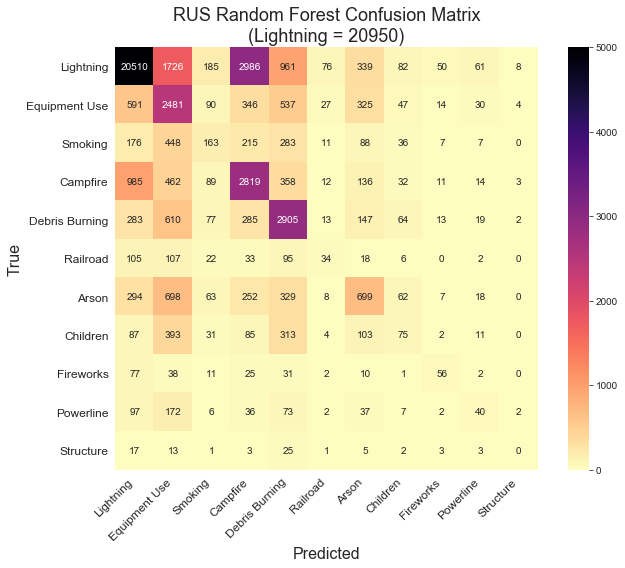

In [46]:
# Running the best BalAcc, Undersampled RF model

# Assigning the random undersampling strategy
RUS_dict_20950 = {
    1.0: 20950,
    4.0: 14761,
    2.0: 13477,
    5.0: 13255,
    7.0: 7291,
    3.0: 4302,
    8.0: 3310,
    11.0: 1424,
    6.0: 1265,
    10.0: 759,
    12.0: 219
}

# Random undersampling the data (Lightning = 20950)
rus = RandomUnderSampler(sampling_strategy=RUS_dict_20950)
X_rus_train, Y_rus_train = rus.fit_resample(X_rf_train, Y_rf_train)

# Instantiating the best WF1 RF model with the undersampled data
rfc_rus_balacc = RandomForestClassifier(criterion = 'gini', 
                                 n_estimators = 500, 
                                 max_depth = 20, 
                                 n_jobs = -1)
rfc_rus_balacc.fit(X_rus_train, Y_rus_train)
Y_rfc_rus_balacc_pred = rfc_rus_balacc.predict(X_rf_test)

# Model metrics
BalAccTst_rfc_rus_balacc = balanced_accuracy_score(Y_rf_test, Y_rfc_rus_balacc_pred)
WF1Tst_rfc_rus_balacc = f1_score(Y_rf_test, Y_rfc_rus_balacc_pred, average='weighted')

print('Balanced accuracy: ', BalAccTst_rfc_rus_balacc)
print('Weighted F1 score: ', WF1Tst_rfc_rus_balacc)


# Gradient Boosted Trees confusion matrix
rfc_rus_balacc_cfmx = pd.crosstab(Y_rf_test, Y_rfc_rus_balacc_pred)

plt.figure(figsize=(10,8))
sns.heatmap(rfc_rus_balacc_cfmx, 
            xticklabels = cause_labels, 
            yticklabels = cause_labels,
            annot = True,
            fmt = 'g',
            square = True, 
            vmax = 5000,
            vmin = 0,
            cmap = 'magma_r')
plt.title('RUS Random Forest Confusion Matrix\n(Lightning = 20950)', size=18)
plt.ylabel('True', size=16)
plt.yticks(size=12)
plt.xlabel('Predicted', size=16)
plt.xticks(rotation=45, size=12, horizontalalignment='right')
plt.tight_layout()
plt.savefig('./Figures/RUSRF_n500_md20_BestBalAcc.png', dpi=300, transparent=True)
plt.show()

In [47]:
# # Grid search for Random Forest model using random under sampled
# # data bringing Lightning class down to 60950 samples.  Best WF1 model.

# # Assigning the random undersampling strategy
# RUS_dict_60950 = {
#     1.0: 60950,
#     4.0: 14761,
#     2.0: 13477,
#     5.0: 13255,
#     7.0: 7291,
#     3.0: 4302,
#     8.0: 3310,
#     11.0: 1424,
#     6.0: 1265,
#     10.0: 759,
#     12.0: 219
# }

# # Performing the random undersampling
# rus = RandomUnderSampler(sampling_strategy=RUS_dict_60950)
# X_rus_train, Y_rus_train = rus.fit_resample(X_rf_train, Y_rf_train)
    

# criterion = ['gini']
# n_est = [10, 100, 250, 500]
# max_depth = [10, 20, 30, 40, 50]

# print('Crit\tN_est\tMaxDep\tBalAccTst\tWF1Tst')
# for crit in criterion:
#     for n in n_est:
#         for md in max_depth:
#             rfc_rus = RandomForestClassifier(criterion=crit, 
#                                              n_estimators=n, 
#                                              max_depth=md, 
#                                              n_jobs=-1)
#             rfc_rus.fit(X_rus_train, Y_rus_train)
#             Y_rfc_rus_pred = rfc_rus.predict(X_rf_test)
            
#             BalAccTst = balanced_accuracy_score(Y_rf_test, Y_rfc_rus_pred)
#             WF1Tst = f1_score(Y_rf_test, Y_rfc_rus_pred, average='weighted')

#             print(crit, ', ', n, ', ', md, ':\t', BalAccTst, '\t', WF1Tst)

In [48]:
# # Grid search results

# Crit	N_est	MaxDep	BalAccTst	WF1Tst
# gini ,  10 ,  10 :	 0.2246362952573844 	 0.6249664893670406
# gini ,  10 ,  20 :	 0.27879108525152385 	 0.6544632079332918
# gini ,  10 ,  30 :	 0.27902700731130614 	 0.6459987582656258
# gini ,  10 ,  40 :	 0.2834179738543999 	 0.6469252230851438
# gini ,  10 ,  50 :	 0.2813368135992829 	 0.6456493258416983
# gini ,  100 ,  10 :	 0.22544887069621833 	 0.6263252042389903
# gini ,  100 ,  20 :	 0.2818583181865429 	 0.6619807351200708
# gini ,  100 ,  30 :	 0.28695090295575026 	 0.6531138072306217
# gini ,  100 ,  40 :	 0.28608101164715277 	 0.652039550439632
# gini ,  100 ,  50 :	 0.2873682751794275 	 0.6525422456873449
# gini ,  250 ,  10 :	 0.2272197653378936 	 0.6283174084600938
# gini ,  250 ,  20 :	 0.2825529895478468 	 0.6636616843858323  ### Best WF1
# gini ,  250 ,  30 :	 0.28629590521863696 	 0.6527128829959183
# gini ,  250 ,  40 :	 0.286306005919089 		 0.6525848183742877
# gini ,  250 ,  50 :	 0.28688140387139677 	 0.6528482137519599
# gini ,  500 ,  10 :	 0.22777438975242423 	 0.6287655953235058
# gini ,  500 ,  20 :	 0.28220717499513015 	 0.6632372610759404
# gini ,  500 ,  30 :	 0.28643028730500447 	 0.6527477706337892
# gini ,  500 ,  40 :	 0.2891024360263899 	 0.6531950408538756
# gini ,  500 ,  50 :	 0.2865355829117456 	 0.6527942928824503

Balanced accuracy:  0.2805759351069341
Weighted F1 score:  0.6613460279722293


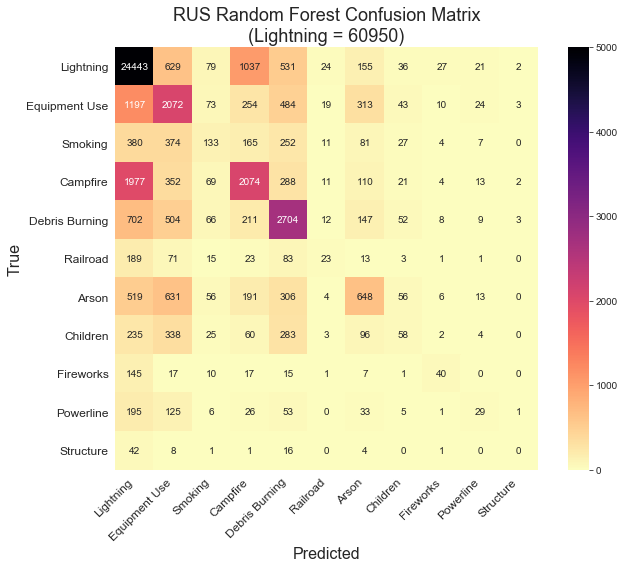

In [49]:
# Running the best WF1, Undersampled RF model

# Assigning the random undersampling strategy
RUS_dict_60950 = {
    1.0: 60950,
    4.0: 14761,
    2.0: 13477,
    5.0: 13255,
    7.0: 7291,
    3.0: 4302,
    8.0: 3310,
    11.0: 1424,
    6.0: 1265,
    10.0: 759,
    12.0: 219
}

# Random undersampling the data (Lightning = 60950)
rus = RandomUnderSampler(sampling_strategy=RUS_dict_60950)
X_rus_train, Y_rus_train = rus.fit_resample(X_rf_train, Y_rf_train)

# Instantiating the best WF1 RF model with the undersampled data
rfc_rus_WF1 = RandomForestClassifier(criterion = 'gini', 
                                 n_estimators = 250, 
                                 max_depth = 20, 
                                 n_jobs = -1)
rfc_rus_WF1.fit(X_rus_train, Y_rus_train)
Y_rfc_rus_WF1_pred = rfc_rus_WF1.predict(X_rf_test)

# Model metrics
BalAccTst_rfc_rus_WF1 = balanced_accuracy_score(Y_rf_test, Y_rfc_rus_WF1_pred)
WF1Tst_rfc_rus_WF1 = f1_score(Y_rf_test, Y_rfc_rus_WF1_pred, average='weighted')

print('Balanced accuracy: ', BalAccTst_rfc_rus_WF1)
print('Weighted F1 score: ', WF1Tst_rfc_rus_WF1)


# Gradient Boosted Trees confusion matrix
rfc_rus_WF1_cfmx = pd.crosstab(Y_rf_test, Y_rfc_rus_WF1_pred)

plt.figure(figsize=(10,8))
sns.heatmap(rfc_rus_WF1_cfmx, 
            xticklabels = cause_labels, 
            yticklabels = cause_labels,
            annot = True,
            fmt = 'g',
            square = True, 
            vmax = 5000,
            vmin = 0,
            cmap = 'magma_r')
plt.title('RUS Random Forest Confusion Matrix\n(Lightning = 60950)', size=18)
plt.ylabel('True', size=16)
plt.yticks(size=12)
plt.xlabel('Predicted', size=16)
plt.xticks(rotation=45, size=12, horizontalalignment='right')
plt.tight_layout()
plt.savefig('./Figures/RUSRF_n250_md20_BestWF1.png', dpi=300, transparent=True)
plt.show()

# SMOTE

In [50]:
# Orginial class counts
Y_rf_train_valuecounts = Y_rf_train.value_counts()
Y_rf_train_valuecounts

1.0     80950
4.0     14761
2.0     13477
5.0     13255
7.0      7291
3.0      4302
8.0      3310
11.0     1424
6.0      1265
10.0      759
12.0      219
Name: STAT_CAUSE_CODE, dtype: int64

In [51]:
# # SMOTE augmenting the data by one multiplicative factor each time through the grid search
# # until the samples are oversampled by a factor of 6.
# # Grid search on each SMOTE augmentation.

# criterion = ['gini']
# n_est = [10, 100, 250, 500]
# max_depth = [20, 30, 40]
# multiple = 2

# print('Mult\tCrit\tN_est\tMaxDep\tBalAccTst\tWF1Tst')

# while multiple != 6:
#     # Creating a dictionary of values for the SMOTE function to upsample each class to.
#     # Increasing the multiplicative factor on smote values up till 5
#     smote_dict = dict(zip(Y_rf_train_valuecounts.index, (Y_rf_train_valuecounts * multiple)))
#     smote_dict[1.0] = Y_rf_train_valuecounts[1]

#     # Instantiating the SMOTE class and augmenting the training data
#     smote = SMOTE(sampling_strategy=smote_dict)
#     X_rf_sm_train, Y_rf_sm_train = smote.fit_resample(X_rf_train, Y_rf_train)

#     # Grid search through hyperparameters
#     for crit in criterion:
#         for n in n_est:
#             for md in max_depth:
#                 rfc_sm = RandomForestClassifier(criterion=crit, 
#                                                  n_estimators=n, 
#                                                  max_depth=md, 
#                                                  n_jobs=-1)
#                 rfc_sm.fit(X_rf_sm_train, Y_rf_sm_train)
#                 Y_rf_sm_pred = rfc_sm.predict(X_rf_test)

#                 BalAccTst_sm = balanced_accuracy_score(Y_rf_test, Y_rf_sm_pred)
#                 WF1Tst_sm = f1_score(Y_rf_test, Y_rf_sm_pred, average='weighted')

#                 print(multiple, '\t', crit, ', ', n, ', ', md, ':\t', BalAccTst_sm, '\t', WF1Tst_sm)
#     multiple += 1

In [52]:
# Random forest, various SMOTE augmentations
# Grid search results


# Mult	Crit	N_est	MaxDep	BalAccTst			WF1Tst
# 2 	 gini ,  10 ,  20 :	 0.2839999861053649 	 0.6580886099755875
# 2 	 gini ,  10 ,  30 :	 0.28007552018020687 	 0.6471219093063233
# 2 	 gini ,  10 ,  40 :	 0.28200092962224743 	 0.6475162468482456
# 2 	 gini ,  100 ,  20 :	 0.284348997368784 	 0.6666081329129544
# 2 	 gini ,  100 ,  30 :	 0.28846573695894256 	 0.6557758839085175
# 2 	 gini ,  100 ,  40 :	 0.2876729851263749 	 0.6536014487629849
# 2 	 gini ,  250 ,  20 :	 0.2852661254977541 	 0.6665538063425109
# 2 	 gini ,  250 ,  30 :	 0.2867013626993083 	 0.6549454984725236
# 2 	 gini ,  250 ,  40 :	 0.2862074603921532 	 0.6530113592469351
# 2 	 gini ,  500 ,  20 :	 0.2858335995275241 	 0.6677782784083037  ## WF1
# 2 	 gini ,  500 ,  30 :	 0.2886149372842303 	 0.6555682507148666
# 2 	 gini ,  500 ,  40 :	 0.28684297823829885 	 0.6535552918333362
# 3 	 gini ,  10 ,  20 :	 0.2886017386984312 	 0.6578383980090042
# 3 	 gini ,  10 ,  30 :	 0.28223953347939906 	 0.6462383563362405
# 3 	 gini ,  10 ,  40 :	 0.28684992033109835 	 0.6468914670374633
# 3 	 gini ,  100 ,  20 :	 0.29376650324414444 	 0.666414202483889
# 3 	 gini ,  100 ,  30 :	 0.29110379445916634 	 0.6530302409955279
# 3 	 gini ,  100 ,  40 :	 0.2917897607176467 	 0.6523845576459414
# 3 	 gini ,  250 ,  20 :	 0.2949572819140807 	 0.6677297923534324
# 3 	 gini ,  250 ,  30 :	 0.2912402593886539 	 0.6540532988554044
# 3 	 gini ,  250 ,  40 :	 0.290732587795616 	 0.6517165214111305
# 3 	 gini ,  500 ,  20 :	 0.29311574137145807 	 0.6668811424432133
# 3 	 gini ,  500 ,  30 :	 0.29132470281633294 	 0.6543448956979974
# 3 	 gini ,  500 ,  40 :	 0.28971828238460445 	 0.6519526447337151
# 4 	 gini ,  10 ,  20 :	 0.2931402468814186 	 0.6512115408962565
# 4 	 gini ,  10 ,  30 :	 0.28923043132450976 	 0.6456463642950548
# 4 	 gini ,  10 ,  40 :	 0.2847739178250677 	 0.6429263001292986
# 4 	 gini ,  100 ,  20 :	 0.2957694802731099 	 0.6605690803665525
# 4 	 gini ,  100 ,  30 :	 0.2928753817048946 	 0.6509414531661131
# 4 	 gini ,  100 ,  40 :	 0.29307540628966844 	 0.6504249830958125
# 4 	 gini ,  250 ,  20 :	 0.29721893864503296 	 0.66146621662269
# 4 	 gini ,  250 ,  30 :	 0.29501158569362557 	 0.65166568625314
# 4 	 gini ,  250 ,  40 :	 0.2916473716814804 	 0.6501881930222128
# 4 	 gini ,  500 ,  20 :	 0.29844413960921545 	 0.6620996881881479
# 4 	 gini ,  500 ,  30 :	 0.2937645859919004 	 0.6517996975495873
# 4 	 gini ,  500 ,  40 :	 0.2936359612044537 	 0.6509658405861117
# 5 	 gini ,  10 ,  20 :	 0.2966284723805075 	 0.6506204503765062
# 5 	 gini ,  10 ,  30 :	 0.2896124025279329 	 0.642939185330787
# 5 	 gini ,  10 ,  40 :	 0.2870491586118852 	 0.6429168773190388
# 5 	 gini ,  100 ,  20 :	 0.2991329646877705 	 0.6556599836595417
# 5 	 gini ,  100 ,  30 :	 0.2924400666993999 	 0.6493870295204881
# 5 	 gini ,  100 ,  40 :	 0.2909655823541912 	 0.6471818544666206
# 5 	 gini ,  250 ,  20 :	 0.29844166025162705 	 0.6558077013221401
# 5 	 gini ,  250 ,  30 :	 0.29558283494979143 	 0.6502443634583926
# 5 	 gini ,  250 ,  40 :	 0.2922055078871562 	 0.6482524738845509
# 5 	 gini ,  500 ,  20 :	 0.29923281861014267 	 0.6560730208604848  ## BalAcc
# 5 	 gini ,  500 ,  30 :	 0.2932557322459741 	 0.6493766839080897
# 5 	 gini ,  500 ,  40 :	 0.29270314283578647 	 0.6484605024547829

0.28803123972252825
0.6677030638030229


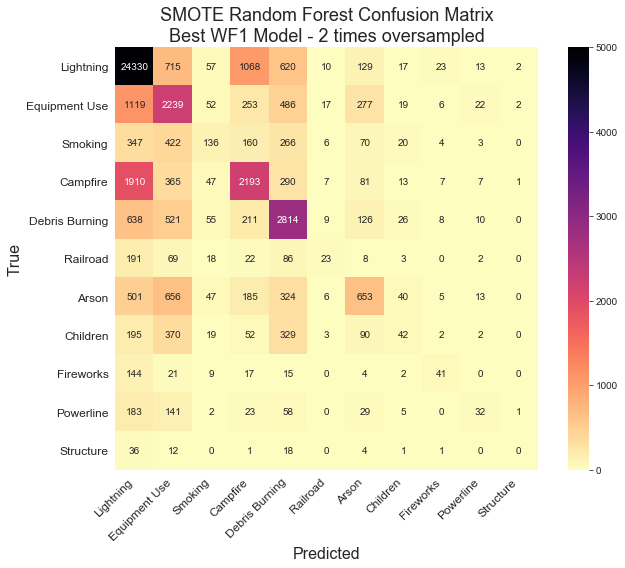

In [53]:
# Running the best WF1 SMOTE model

# Creating a dictionary of values for the SMOTE function to upsample each class to.
smote_dict = dict(zip(Y_rf_train_valuecounts.index, (Y_rf_train_valuecounts * 2)))
smote_dict[1.0] = Y_rf_train_valuecounts[1]

# Instantiating the SMOTE class and augmenting the training data
smote = SMOTE(sampling_strategy=smote_dict)
X_rf_sm_train, Y_rf_sm_train = smote.fit_resample(X_rf_train, Y_rf_train)

# Random forest model instantiation
rfc_sm_WF1 = RandomForestClassifier(criterion='gini', 
                                 n_estimators=500, 
                                 max_depth=20, 
                                 n_jobs=-1)
rfc_sm_WF1.fit(X_rf_sm_train, Y_rf_sm_train)
Y_rf_sm_WF1_pred = rfc_sm_WF1.predict(X_rf_test)

# Model metrics
BalAccTst_sm = balanced_accuracy_score(Y_rf_test, Y_rf_sm_WF1_pred)
WF1Tst_sm = f1_score(Y_rf_test, Y_rf_sm_WF1_pred, average='weighted')

print(BalAccTst_sm)
print(WF1Tst_sm)

# SMOTE RF (WF1) confusion matrix
rfc_sm_WF1_cfmx = pd.crosstab(Y_rf_test, Y_rf_sm_WF1_pred)

plt.figure(figsize=(10,8))
sns.heatmap(rfc_sm_WF1_cfmx, 
            xticklabels = cause_labels, 
            yticklabels = cause_labels,
            annot = True,
            fmt = 'g',
            square = True, 
            vmax = 5000,
            vmin = 0,
            cmap = 'magma_r')
plt.title('SMOTE Random Forest Confusion Matrix\nBest WF1 Model - 2 times oversampled', size=18)
plt.ylabel('True', size=16)
plt.yticks(size=12)
plt.xlabel('Predicted', size=16)
plt.xticks(rotation=45, size=12, horizontalalignment='right')
plt.tight_layout()
plt.savefig('./Figures/SMOTERF_n500_md20_BestWF1.png', dpi=300, transparent=True)
plt.show()

In [75]:
# Looking at the sample distribution for the SMOTE WF1 model

# Creating a dictionary of values for the SMOTE function to upsample each class to.
smote_dict = dict(zip(Y_rf_train_valuecounts.index, (Y_rf_train_valuecounts * 2)))
smote_dict[1.0] = Y_rf_train_valuecounts[1]

# Instantiating the SMOTE class and augmenting the training data
smote = SMOTE(sampling_strategy=smote_dict)
X_rf_sm_train, Y_rf_sm_train = smote.fit_resample(X_rf_train, Y_rf_train)

pd.DataFrame(Y_rf_sm_train)[0].value_counts()

1.0     80950
4.0     29522
2.0     26954
5.0     26510
7.0     14582
3.0      8604
8.0      6620
11.0     2848
6.0      2530
10.0     1518
12.0      438
Name: 0, dtype: int64

0.29862933259804025
0.654755473572584


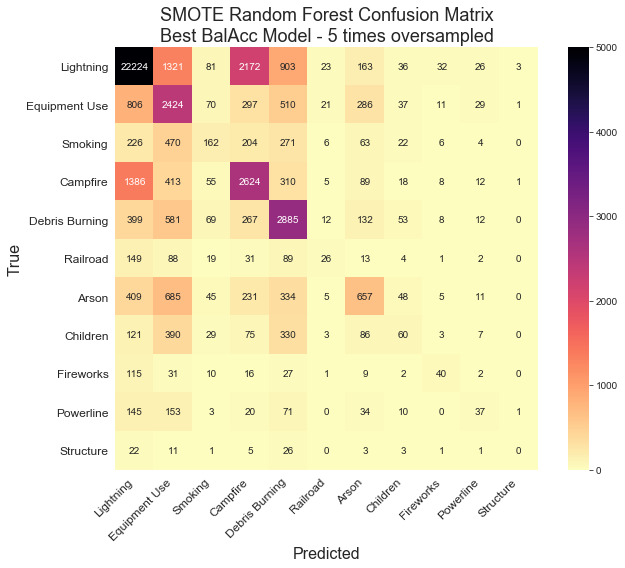

In [54]:
# Running the best BalAcc SMOTE model

# Creating a dictionary of values for the SMOTE function to upsample each class to.
smote_dict = dict(zip(Y_rf_train_valuecounts.index, (Y_rf_train_valuecounts * 5)))
smote_dict[1.0] = Y_rf_train_valuecounts[1]

# Instantiating the SMOTE class and augmenting the training data
smote = SMOTE(sampling_strategy=smote_dict)
X_rf_sm_train, Y_rf_sm_train = smote.fit_resample(X_rf_train, Y_rf_train)

# Random forest model instantiation
rfc_sm_BalAcc = RandomForestClassifier(criterion='gini', 
                                 n_estimators=500, 
                                 max_depth=20, 
                                 n_jobs=-1)
rfc_sm_BalAcc.fit(X_rf_sm_train, Y_rf_sm_train)
Y_rf_sm_BalAcc_pred = rfc_sm_BalAcc.predict(X_rf_test)

# Model metrics
BalAccTst_sm = balanced_accuracy_score(Y_rf_test, Y_rf_sm_BalAcc_pred)
WF1Tst_sm = f1_score(Y_rf_test, Y_rf_sm_BalAcc_pred, average='weighted')

print(BalAccTst_sm)
print(WF1Tst_sm)

# SMOTE RF (BalAcc) confusion matrix
rfc_sm_BalAcc_cfmx = pd.crosstab(Y_rf_test, Y_rf_sm_BalAcc_pred)

plt.figure(figsize=(10,8))
sns.heatmap(rfc_sm_BalAcc_cfmx, 
            xticklabels = cause_labels, 
            yticklabels = cause_labels,
            annot = True,
            fmt = 'g',
            square = True, 
            vmax = 5000,
            vmin = 0,
            cmap = 'magma_r')
plt.title('SMOTE Random Forest Confusion Matrix\nBest BalAcc Model - 5 times oversampled', size=18)
plt.ylabel('True', size=16)
plt.yticks(size=12)
plt.xlabel('Predicted', size=16)
plt.xticks(rotation=45, size=12, horizontalalignment='right')
plt.tight_layout()
plt.savefig('./Figures/SMOTERF_n500_md20_BestBalAcc.png', dpi=300, transparent=True)
plt.show()

In [76]:
# Looking at the sample distribution for the SMOTE WF1 model

# Creating a dictionary of values for the SMOTE function to upsample each class to.
smote_dict = dict(zip(Y_rf_train_valuecounts.index, (Y_rf_train_valuecounts * 5)))
smote_dict[1.0] = Y_rf_train_valuecounts[1]

# Instantiating the SMOTE class and augmenting the training data
smote = SMOTE(sampling_strategy=smote_dict)
X_rf_sm_train, Y_rf_sm_train = smote.fit_resample(X_rf_train, Y_rf_train)

pd.DataFrame(Y_rf_sm_train)[0].value_counts()

1.0     80950
4.0     73805
2.0     67385
5.0     66275
7.0     36455
3.0     21510
8.0     16550
11.0     7120
6.0      6325
10.0     3795
12.0     1095
Name: 0, dtype: int64

In [61]:
# # Grid search using SMOTE sampling_strategy='not majority'

# # Instantiating the SMOTE class and augmenting the training data
# smote = SMOTE(sampling_strategy='not majority')
# X_rf_sm_train, Y_rf_sm_train = smote.fit_resample(X_rf_train, Y_rf_train)

# # Grid search hyperparameter space
# criterion = ['gini']
# n_est = [10, 100, 250, 500]
# max_depth = [20, 30, 40]

# # Grid search through hyperparameters
# for crit in criterion:
#     for n in n_est:
#         for md in max_depth:
#             rfc_sm = RandomForestClassifier(criterion=crit, 
#                                              n_estimators=n, 
#                                              max_depth=md, 
#                                              n_jobs=-1)
#             rfc_sm.fit(X_rf_sm_train, Y_rf_sm_train)
#             Y_rf_sm_pred = rfc_sm.predict(X_rf_test)

#             BalAccTst_sm = balanced_accuracy_score(Y_rf_test, Y_rf_sm_pred)
#             WF1Tst_sm = f1_score(Y_rf_test, Y_rf_sm_pred, average='weighted')

#             print(crit, ', ', n, ', ', md, ':\t', BalAccTst_sm, '\t', WF1Tst_sm)

In [62]:
# SMOTE 'not majority' RF grid search results

# Crit	N_est	MaxDep	BalAccTst				WF1Tst
# gini ,  10 ,  20 :	 0.34872403344948627 	 0.635139933324604
# gini ,  10 ,  30 :	 0.3127954400290277 	 0.637746499279724
# gini ,  10 ,  40 :	 0.31043231099807467 	 0.6357318856878252
# gini ,  100 ,  20 :	 0.3521103594547456 	 0.6439571356939483
# gini ,  100 ,  30 :	 0.3163787225581983 	 0.6425561485419016
# gini ,  100 ,  40 :	 0.3135805084620968 	 0.6412168035389549
# gini ,  250 ,  20 :	 0.3548575348056357 	 0.6459980007767263
# gini ,  250 ,  30 :	 0.3160579166835058 	 0.6429082345824891
# gini ,  250 ,  40 :	 0.31375926524492675 	 0.6421837377997485
# gini ,  500 ,  20 :	 0.35280071576705707 	 0.6455543991835687
# gini ,  500 ,  30 :	 0.3165513663242217 	 0.6428524989777542

# SMOTEENN

In [55]:
# # SMOTEEN augmenting the data by one multiplicative factor each time through 
# # the grid search until the samples are oversampled by a factor of 6.
# # Grid search on each SMOTEENN augmentation.

# criterion = ['gini']
# n_est = [10, 100, 250, 500]
# max_depth = [20, 30, 40]
# multiple = 2

# print('Mult\tCrit\tN_est\tMaxDep\tBalAccTst\tWF1Tst')

# while multiple != 6:
#     # Creating a dictionary of values for the SMOTEEN function to upsample each class to.
#     # Increasing the multiplicative factor on smote values up till 5
#     smoteen_dict = dict(zip(Y_rf_train_valuecounts.index, (Y_rf_train_valuecounts * multiple)))
#     smoteen_dict[1.0] = Y_rf_train_valuecounts[1]

#     # Instantiating the SMOTEENN class and augmenting the training data
#     smoteenn = SMOTEENN(sampling_strategy=smoteen_dict)
#     X_rf_smenn_train, Y_rf_smenn_train = smoteenn.fit_resample(X_rf_train, Y_rf_train)

#     # Grid search through hyperparameters
#     for crit in criterion:
#         for n in n_est:
#             for md in max_depth:
#                 rfc_smenn = RandomForestClassifier(criterion=crit, 
#                                                  n_estimators=n, 
#                                                  max_depth=md, 
#                                                  n_jobs=-1)
#                 rfc_smenn.fit(X_rf_smenn_train, Y_rf_smenn_train)
#                 Y_rf_smenn_pred = rfc_smenn.predict(X_rf_test)

#                 BalAccTst_smenn = balanced_accuracy_score(Y_rf_test, Y_rf_smenn_pred)
#                 WF1Tst_smenn = f1_score(Y_rf_test, Y_rf_smenn_pred, average='weighted')

#                 print(multiple, '\t', crit, ', ', n, ', ', md, ':\t', BalAccTst_smenn, '\t', WF1Tst_smenn)
#     multiple += 1

In [56]:
# SMOTEENN grid search results

# Mult	Crit	N_est	MaxDep	BalAccTst				WF1Tst
# 2 	 gini ,  10 ,  20 :		 0.2715753402446075 	 0.6515539487419431
# 2 	 gini ,  10 ,  30 :		 0.27076055013542316 	 0.6498623692449988
# 2 	 gini ,  10 ,  40 :		 0.26845994500395076 	 0.6484353933850154
# 2 	 gini ,  100 ,  20 :	 0.27311311579551334 	 0.6550984642556921
# 2 	 gini ,  100 ,  30 :	 0.2760885674691255 	 0.6536354615969187
# 2 	 gini ,  100 ,  40 :	 0.27491230834673047 	 0.6535454107957197
# 2 	 gini ,  250 ,  20 :	 0.27539473828746863 	 0.6560150109561508 ## WF1
# 2 	 gini ,  250 ,  30 :	 0.277047745124638 		 0.6546462834947654
# 2 	 gini ,  250 ,  40 :	 0.2755491210318262 	 0.6534663065949528
# 2 	 gini ,  500 ,  20 :	 0.2737772022169939 	 0.6552780807854512
# 2 	 gini ,  500 ,  30 :	 0.2759311475325778 	 0.6540415714219996
# 2 	 gini ,  500 ,  40 :	 0.2761850616122031 	 0.6545312350448672
# 3 	 gini ,  10 ,  20 :		 0.28364509217004685 	 0.6499048754908021
# 3 	 gini ,  10 ,  30 :		 0.2805646866257519 	 0.6486154617287989
# 3 	 gini ,  10 ,  40 :		 0.28110667303647646 	 0.6467974169186507
# 3 	 gini ,  100 ,  20 :	 0.2854796640488603 	 0.6537653703094772
# 3 	 gini ,  100 ,  30 :	 0.28931704603746844 	 0.6521224617144281
# 3 	 gini ,  100 ,  40 :	 0.2885713226188319 	 0.6512880795593351
# 3 	 gini ,  250 ,  20 :	 0.28511162446728444 	 0.6535516895566255
# 3 	 gini ,  250 ,  30 :	 0.2890374385539345 	 0.6517585013771686
# 3 	 gini ,  250 ,  40 :	 0.2877247132848018 	 0.6513725493591074
# 3 	 gini ,  500 ,  20 :	 0.28563437188552965 	 0.6535870683972003
# 3 	 gini ,  500 ,  30 :	 0.2885727965520441 	 0.6519965249314793
# 3 	 gini ,  500 ,  40 :	 0.2892032303838431 	 0.6514676415763397
# 4 	 gini ,  10 ,  20 :		 0.2931776510870447 	 0.6442543545667897
# 4 	 gini ,  10 ,  30 :		 0.2895926425615573 	 0.6442632847734184
# 4 	 gini ,  10 ,  40 :		 0.2908578662567921 	 0.6445396956011764
# 4 	 gini ,  100 ,  20 :	 0.29907175492044114 	 0.6497798585076798
# 4 	 gini ,  100 ,  30 :	 0.29679650632376414 	 0.6463711707942106
# 4 	 gini ,  100 ,  40 :	 0.2980554580292794 	 0.6477158662711541
# 4 	 gini ,  250 ,  20 :	 0.29787754522503856 	 0.6496402409050719
# 4 	 gini ,  250 ,  30 :	 0.29786943377147934 	 0.6477280983342989
# 4 	 gini ,  250 ,  40 :	 0.298248261068558 		 0.6468285991942125
# 4 	 gini ,  500 ,  20 :	 0.29890064183556936 	 0.6502366300768468
# 4 	 gini ,  500 ,  30 :	 0.2997421969395943 	 0.6475369227817597
# 4 	 gini ,  500 ,  40 :	 0.29746299573598106 	 0.646893359970137
# 5 	 gini ,  10 ,  20 :		 0.3022545974666401 	 0.6415639589563197
# 5 	 gini ,  10 ,  30 :		 0.30096745884472786 	 0.6402517795061636
# 5 	 gini ,  10 ,  40 :		 0.3002423643468719 	 0.640877088785621
# 5 	 gini ,  100 ,  20 :	 0.3039715644416008 	 0.6460030101868302
# 5 	 gini ,  100 ,  30 :	 0.30623564603492504 	 0.6424951797187867 ## BalAcc
# 5 	 gini ,  100 ,  40 :	 0.3001250594932738 	 0.6407865888547167
# 5 	 gini ,  250 ,  20 :	 0.30347473723047674 	 0.6453580285148786
# 5 	 gini ,  250 ,  30 :	 0.30465439516973636 	 0.6430085201820522
# 5 	 gini ,  250 ,  40 :	 0.30436013838572384 	 0.642925550731063
# 5 	 gini ,  500 ,  20 :	 0.3033299560139736 	 0.6464772086004185
# 5 	 gini ,  500 ,  30 :	 0.3031326071854417 	 0.642700022627095
# 5 	 gini ,  500 ,  40 :	 0.3028038771523801 	 0.6427365319680222

0.27679205327739376
0.65841124134191


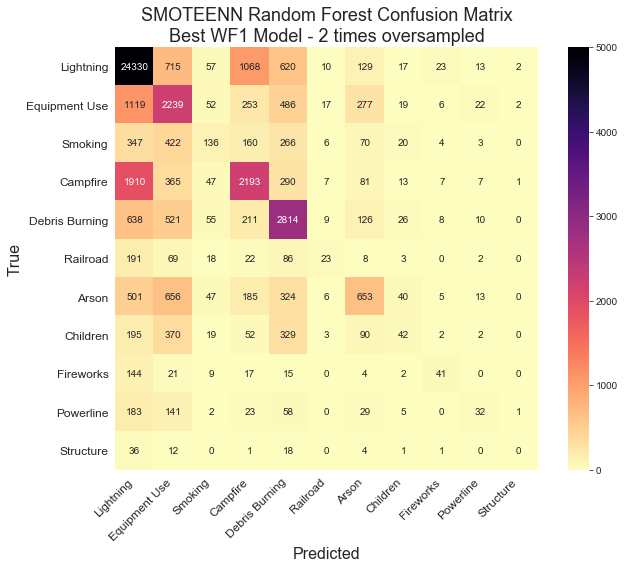

In [81]:
# Best WF1 SMOTEENN model

# Creating a dictionary of values for the SMOTEEN function to upsample each class to.
smoteen_dict = dict(zip(Y_rf_train_valuecounts.index, (Y_rf_train_valuecounts * 2)))
smoteen_dict[1.0] = Y_rf_train_valuecounts[1]

# Instantiating the SMOTEENN class and augmenting the training data
smoteenn_WF1 = SMOTEENN(sampling_strategy=smoteen_dict)
X_rf_smenn_WF1_train, Y_rf_smenn_WF1_train = smoteenn_WF1.fit_resample(X_rf_train, Y_rf_train)

# Instantiating the Random Forest model
rfc_smenn_WF1 = RandomForestClassifier(criterion='gini', 
                                 n_estimators=250, 
                                 max_depth=20, 
                                 n_jobs=-1)
rfc_smenn_WF1.fit(X_rf_smenn_WF1_train, Y_rf_smenn_WF1_train)
Y_rf_smenn_WF1_pred = rfc_smenn_WF1.predict(X_rf_test)

# Model metrics
BalAccTst_smenn_WF1 = balanced_accuracy_score(Y_rf_test, Y_rf_smenn_WF1_pred)
WF1Tst_smenn_WF1 = f1_score(Y_rf_test, Y_rf_smenn_WF1_pred, average='weighted')

print(BalAccTst_smenn_WF1)
print(WF1Tst_smenn_WF1)


# SMOTE RF (WF1) confusion matrix
rfc_smenn_WF1_cfmx = pd.crosstab(Y_rf_test, Y_rf_sm_WF1_pred)

plt.figure(figsize=(10,8))
sns.heatmap(rfc_smenn_WF1_cfmx, 
            xticklabels = cause_labels, 
            yticklabels = cause_labels,
            annot = True,
            fmt = 'g',
            square = True, 
            vmax = 5000,
            vmin = 0,
            cmap = 'magma_r')
plt.title('SMOTEENN Random Forest Confusion Matrix\nBest WF1 Model - 2 times oversampled', size=18)
plt.ylabel('True', size=16)
plt.yticks(size=12)
plt.xlabel('Predicted', size=16)
plt.xticks(rotation=45, size=12, horizontalalignment='right')
plt.tight_layout()
plt.savefig('./Figures/SMOTEENRF_n250_md20_BestWF1.png', dpi=300, transparent=True)
plt.show()

In [77]:
# Looking at the sample distribution for the SMOTEENN WF1 model

# Creating a dictionary of values for the SMOTEENN function to upsample each class to.
smoteen_dict = dict(zip(Y_rf_train_valuecounts.index, (Y_rf_train_valuecounts * 2)))
smoteen_dict[1.0] = Y_rf_train_valuecounts[1]

# Instantiating the SMOTEENN class and augmenting the training data
smoteenn_WF1 = SMOTEENN(sampling_strategy=smoteen_dict)
X_rf_smenn_WF1_train, Y_rf_smenn_WF1_train = smoteenn_WF1.fit_resample(X_rf_train, Y_rf_train)

pd.DataFrame(Y_rf_smenn_WF1_train)[0].value_counts()

1.0     50763
4.0     10645
5.0     10504
2.0      7694
7.0      3614
3.0       951
8.0       494
11.0      331
6.0       287
10.0      235
12.0       27
Name: 0, dtype: int64

0.3025082380747534
0.6411387285644959


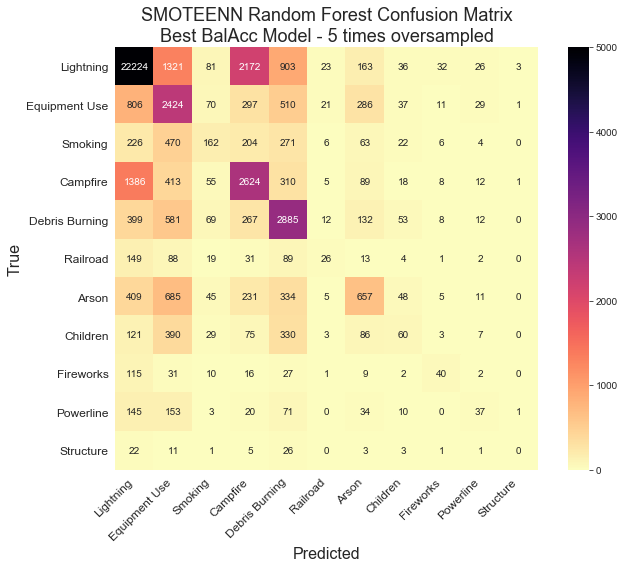

In [58]:
# Best BalAcc SMOTEENN model

# Creating a dictionary of values for the SMOTEEN function to upsample each class to.
smoteen_dict = dict(zip(Y_rf_train_valuecounts.index, (Y_rf_train_valuecounts * 5)))
smoteen_dict[1.0] = Y_rf_train_valuecounts[1]

# Instantiating the SMOTEENN class and augmenting the training data
smoteenn_BalAcc = SMOTEENN(sampling_strategy=smoteen_dict)
X_rf_smenn_BalAcc_train, Y_rf_smenn_BalAcc_train = smoteenn_BalAcc.fit_resample(X_rf_train, Y_rf_train)

# Instantiating the Random Forest model
rfc_smenn_BalAcc = RandomForestClassifier(criterion='gini', 
                                 n_estimators=100, 
                                 max_depth=30, 
                                 n_jobs=-1)
rfc_smenn_BalAcc.fit(X_rf_smenn_BalAcc_train, Y_rf_smenn_BalAcc_train)
Y_rf_smenn_BalAcc_pred = rfc_smenn_BalAcc.predict(X_rf_test)

# Model metrics
BalAccTst_smenn_BalAcc = balanced_accuracy_score(Y_rf_test, Y_rf_smenn_BalAcc_pred)
WF1_smenn_BalAcc = f1_score(Y_rf_test, Y_rf_smenn_BalAcc_pred, average='weighted')

print(BalAccTst_smenn_BalAcc)
print(WF1_smenn_BalAcc)


# SMOTE RF (BalAcc) confusion matrix
rfc_smenn_BalAcc_cfmx = pd.crosstab(Y_rf_test, Y_rf_sm_BalAcc_pred)

plt.figure(figsize=(10,8))
sns.heatmap(rfc_smenn_BalAcc_cfmx, 
            xticklabels = cause_labels, 
            yticklabels = cause_labels,
            annot = True,
            fmt = 'g',
            square = True, 
            vmax = 5000,
            vmin = 0,
            cmap = 'magma_r')
plt.title('SMOTEENN Random Forest Confusion Matrix\nBest BalAcc Model - 5 times oversampled', size=18)
plt.ylabel('True', size=16)
plt.yticks(size=12)
plt.xlabel('Predicted', size=16)
plt.xticks(rotation=45, size=12, horizontalalignment='right')
plt.tight_layout()
plt.savefig('./Figures/SMOTEENRF_n100_md30_BestBalAcc.png', dpi=300, transparent=True)
plt.show()

In [82]:
# Looking at the sample distribution for the SMOTEENN BalAcc model

# Creating a dictionary of values for the SMOTEENN function to upsample each class to.
smoteen_dict = dict(zip(Y_rf_train_valuecounts.index, (Y_rf_train_valuecounts * 5)))
smoteen_dict[1.0] = Y_rf_train_valuecounts[1]

# Instantiating the SMOTEENN class and augmenting the training data
smoteenn_BalAcc = SMOTEENN(sampling_strategy=smoteen_dict)
X_rf_smenn_BalAcc_train, Y_rf_smenn_BalAcc_train = smoteenn_BalAcc.fit_resample(X_rf_train, Y_rf_train)

pd.DataFrame(Y_rf_smenn_BalAcc_train)[0].value_counts()

1.0     46565
4.0     43300
5.0     39368
2.0     34110
7.0     16658
3.0      6011
8.0      3826
11.0     2494
6.0      1873
10.0     1528
12.0      245
Name: 0, dtype: int64

In [59]:
# # Grid search using SMOTEENN sampling_strategy='not majority'

# # Instantiating the SMOTEENN class and augmenting the training data
# smoteenn = SMOTEENN(sampling_strategy='not majority')
# X_rf_smenn_train, Y_rf_smenn_train = smoteenn.fit_resample(X_rf_train, Y_rf_train)

# # Grid search hyperparameter space
# criterion = ['gini']
# n_est = [10, 100, 250, 500]
# max_depth = [20, 30, 40]

# # Grid search through hyperparameters
# for crit in criterion:
#     for n in n_est:
#         for md in max_depth:
#             rfc_smenn = RandomForestClassifier(criterion=crit, 
#                                              n_estimators=n, 
#                                              max_depth=md, 
#                                              n_jobs=-1)
#             rfc_smenn.fit(X_rf_smenn_train, Y_rf_smenn_train)
#             Y_rf_smenn_pred = rfc_smenn.predict(X_rf_test)

#             BalAccTst_smenn = balanced_accuracy_score(Y_rf_test, Y_rf_smenn_pred)
#             WF1Tst_smenn = f1_score(Y_rf_test, Y_rf_smenn_pred, average='weighted')

#             print(crit, ', ', n, ', ', md, ':\t', BalAccTst_smenn, '\t', WF1Tst_smenn)

In [60]:
# SMOTEENN 'not majority' RF grid search results

# Crit	N_est	MaxDep	BalAccTst				WF1Tst
# gini ,  10 ,  20 :	 0.35967694754172774 	 0.6141338370431307
# gini ,  10 ,  30 :	 0.33157506060454345 	 0.6213301351408873
# gini ,  10 ,  40 :	 0.33358998172195126 	 0.6220240667535434
# gini ,  100 ,  20 :	 0.3756023439220973 	 0.6243889324960272  ## BalAcc
# gini ,  100 ,  30 :	 0.3409380299539728 	 0.6250361791813226
# gini ,  100 ,  40 :	 0.3389081859320933 	 0.6249911233414824
# gini ,  250 ,  20 :	 0.37436422886932963 	 0.6242410750691874
# gini ,  250 ,  30 :	 0.340272254606621 		 0.6269238901390807  ## WF1
# gini ,  250 ,  40 :	 0.3396646728357611 	 0.6255224212411505
# gini ,  500 ,  20 :	 0.37339430902303145 	 0.6249944139031801
# gini ,  500 ,  30 :	 0.34097362703029876 	 0.6261565061700692
# gini ,  500 ,  40 :	 0.34131883845903166 	 0.6259987602284263

# Balanced Random Forest

[Imbalanced learn user guide](https://imbalanced-learn.readthedocs.io/en/stable/ensemble.html#forest-of-randomized-trees)

In [70]:
# # Balanced Random Forest Grid search

# # Grid search hyperparameter space
# samplers = ['not minority', 'all']
# n_est = [10, 100, 250, 500]
# max_depth = [20, 30, 40]

# print('Samp\tN_est\tMaxDep\tBalAcc\tWF1')

# # Grid search instantiation
# for s in samplers:
#     for n in n_est:
#         for md in max_depth:
#             brf = BalancedRandomForestClassifier(criterion='gini',
#                                                  class_weight='balanced_subsample',
#                                                  sampling_strategy=s, 
#                                                  n_estimators=n, 
#                                                  max_depth=md)
#             brf.fit(X_rf_train, Y_rf_train)
#             Y_brf_pred = brf.predict(X_rf_test)


#             # Model metrics
#             BalAccTst_brf = balanced_accuracy_score(Y_rf_test, Y_brf_pred)
#             WF1Tst_brf = f1_score(Y_rf_test, Y_brf_pred, average='weighted')

#             print(s, '\t', n, '\t', md, '\t', BalAccTst_brf, '\t', WF1Tst_brf)

Samp	N_est	MaxDep	BalAcc	WF1
not minority 	 10 	 20 	 0.3457869638881912 	 0.49129956584227114
not minority 	 10 	 30 	 0.357645292925701 	 0.4959767802384008
not minority 	 10 	 40 	 0.35212115455249754 	 0.48657797913923695
not minority 	 100 	 20 	 0.394096188744833 	 0.5283783829054927
not minority 	 100 	 30 	 0.39824263058451825 	 0.5237668827609152
not minority 	 100 	 40 	 0.395783623015396 	 0.5224284404916737
not minority 	 250 	 20 	 0.4038424217659717 	 0.5232651838086705
not minority 	 250 	 30 	 0.4031670483334508 	 0.5245294164090841
not minority 	 250 	 40 	 0.4012058540176163 	 0.5298695233723862
not minority 	 500 	 20 	 0.40378174837668956 	 0.5282581941902924
not minority 	 500 	 30 	 0.4042870996172132 	 0.5290459170585529
not minority 	 500 	 40 	 0.4009764083602107 	 0.5287154897510897
all 	 10 	 20 	 0.3455979603313162 	 0.48616696758636724
all 	 10 	 30 	 0.3552388434210594 	 0.49161848762834104
all 	 10 	 40 	 0.3508966773893421 	 0.48455545656882204
all 	 100

In [ ]:
# Samp			N_est	MaxDep	BalAcc					WF1
# not minority 	 10 	 20 	 0.3457869638881912 	 0.49129956584227114
# not minority 	 10 	 30 	 0.357645292925701 		 0.4959767802384008
# not minority 	 10 	 40 	 0.35212115455249754 	 0.48657797913923695
# not minority 	 100 	 20 	 0.394096188744833 		 0.5283783829054927
# not minority 	 100 	 30 	 0.39824263058451825 	 0.5237668827609152
# not minority 	 100 	 40 	 0.395783623015396 		 0.5224284404916737
# not minority 	 250 	 20 	 0.4038424217659717 	 0.5232651838086705
# not minority 	 250 	 30 	 0.4031670483334508 	 0.5245294164090841
# not minority 	 250 	 40 	 0.4012058540176163 	 0.5298695233723862
# not minority 	 500 	 20 	 0.40378174837668956 	 0.5282581941902924
# not minority 	 500 	 30 	 0.4042870996172132 	 0.5290459170585529
# not minority 	 500 	 40 	 0.4009764083602107 	 0.5287154897510897
# all 			 10 	 20 	 0.3455979603313162 	 0.48616696758636724
# all 			 10 	 30 	 0.3552388434210594 	 0.49161848762834104
# all 			 10 	 40 	 0.3508966773893421 	 0.48455545656882204
# all 			 100 	 20 	 0.3976199871348161 	 0.5286704766969633
# all 			 100 	 30 	 0.3995681876566293 	 0.5266056018213403
# all 			 100 	 40 	 0.3961203837288842 	 0.52265271510677
# all 			 250 	 20 	 0.40453614268471366 	 0.5309023051682943  ## Best for both
# all 			 250 	 30 	 0.4008038852351671 	 0.5263760887435331
# all 			 250 	 40 	 0.4013582577144008 	 0.5282751691166224
# all 			 500 	 20 	 0.4033647256218794 	 0.5255986752750871
# all 			 500 	 30 	 0.40364001269389144 	 0.5280391373480763
# all 			 500 	 40 	 0.4002889619916983 	 0.5284176647882964

Balanced accuracy:  0.4016422077472815
Weighted F1 score:  0.5286900894338672


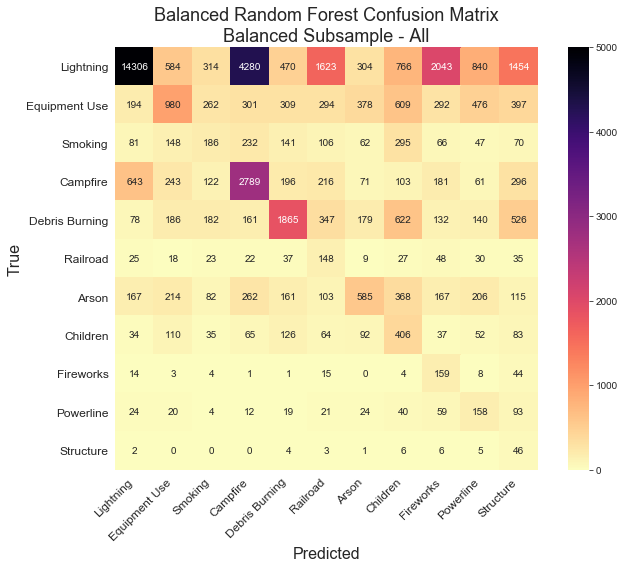

In [73]:
# Imbalanced-learn's Balanced Random Forest, using defaults

brf = BalancedRandomForestClassifier(criterion='gini',
                                     class_weight='balanced_subsample',
                                     sampling_strategy='all', 
                                     n_estimators=250, 
                                     max_depth=20)
brf.fit(X_rf_train, Y_rf_train)
Y_brf_pred = brf.predict(X_rf_test)

# Model metrics
BalAccTst_brf = balanced_accuracy_score(Y_rf_test, Y_brf_pred)
WF1Tst_brf = f1_score(Y_rf_test, Y_brf_pred, average='weighted')

print('Balanced accuracy: ', BalAccTst_brf)
print('Weighted F1 score: ', WF1Tst_brf)


# Balanced Random Forest confusion matrix
brf_cfmx = pd.crosstab(Y_rf_test, Y_brf_pred)

plt.figure(figsize=(10,8))
sns.heatmap(brf_cfmx, 
            xticklabels = cause_labels, 
            yticklabels = cause_labels,
            annot = True,
            fmt = 'g',
            square = True, 
            vmax = 5000,
            vmin = 0,
            cmap = 'magma_r')
plt.title('Balanced Random Forest Confusion Matrix\nBalanced Subsample - All', size=18)
plt.ylabel('True', size=16)
plt.yticks(size=12)
plt.xlabel('Predicted', size=16)
plt.xticks(rotation=45, size=12, horizontalalignment='right')
plt.tight_layout()
plt.savefig('./Figures/BRF_n250_md20_cwBSS_ssA_Best.png', dpi=300, transparent=True)
plt.show()